STEP 1 — Imports and file path

In [1]:
!pip install pandas
!pip install openpyxl

from pathlib import Path
import pandas as pd
import numpy as np


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from pathlib import Path

DATA_FILE = Path("data/raw/AtrofiaMuscularRadiomicaML_1.xlsx")
assert DATA_FILE.exists(), f"Data file not found: {DATA_FILE.resolve()}"
print(f"File size: {DATA_FILE.stat().st_size / (1024**2):.2f} MB")

File size: 2.33 MB


STEP 2 — Clean, publication-ready Excel loader

In [3]:
def load_excel_data(
    file_path: Path,
    sheets: list[str] | None = None,
    required_columns: dict[str, list[str]] | None = None,
) -> dict[str, pd.DataFrame]:
    """
    Load one or multiple sheets from an Excel file and apply basic validation.

    Parameters
    ----------
    file_path : Path
        Path to the Excel (.xlsx) file.
    sheets : list[str] or None
        List of sheet names to load. If None, all sheets are loaded.
    required_columns : dict or None
        Dictionary mapping sheet names to required column names.

    Returns
    -------
    dict[str, pd.DataFrame]
        Dictionary with sheet names as keys and DataFrames as values.
    """
    file_path = Path(file_path)
    xls = pd.ExcelFile(file_path)

    available_sheets = xls.sheet_names
    if sheets is None:
        sheets = available_sheets

    missing_sheets = [s for s in sheets if s not in available_sheets]
    if missing_sheets:
        raise ValueError(
            f"Requested sheets not found: {missing_sheets}. "
            f"Available sheets: {available_sheets}"
        )

    tables: dict[str, pd.DataFrame] = {}

    for sheet in sheets:
        df = pd.read_excel(xls, sheet_name=sheet)

        # Standardize column names
        df.columns = (
            df.columns.astype(str)
            .str.strip()
            .str.lower()
            .str.replace(" ", "_")
        )

        # Drop fully empty columns
        df = df.dropna(axis=1, how="all")

        # Validate required columns
        if required_columns and sheet in required_columns:
            required = [
                c.lower().strip().replace(" ", "_")
                for c in required_columns[sheet]
            ]
            missing = [c for c in required if c not in df.columns]
            if missing:
                raise ValueError(
                    f"Sheet '{sheet}' is missing required columns: {missing}. "
                    f"Found columns: {list(df.columns)}"
                )

        tables[sheet] = df

    return tables


In [4]:
tables = load_excel_data(DATA_FILE)

print("Loaded sheets:")
for name, df in tables.items():
    print(f"- {name}: shape={df.shape}")

Loaded sheets:
- Planilha1: shape=(571, 328)


In [5]:
# Inspect first rows of each sheet
for name, df in tables.items():
    print(f"\n=== {name} ===")
    display(df.head(3))


=== Planilha1 ===


,identificação_imagem,"estado_toxina(0=pre,1=pós)","bloco_de_estudo(0=1ºbloco,1=2ºbloco)","grupo_estudo(gc,g2,g5,g7,g14)","lateralidade(0=dir,1=esq)","aumento_de_dados(0=não,1=sim)",shape_elongation_pre,shapeflatness_pre,shapeleastaxislength_pre,shapemajoraxislength_pre,...,glszmsmallarealowgraylevelemphasis_delta,glszmzoneentropy_delta,glszmzonepercentage_delta,glszmzonevariance_delta,ngtdmbusyness_delta,ngtdmcoarseness_delta,ngtdmcomplexity_delta,ngtdmcontrast_delta,ngtdmstrength_delta,pct_area_contratil
0,GC CX1 R0 (2) 16:34:23,0,1,GC,0,0,0.112424,0,0,329.273323,...,0.037473,-0.640015,-0.000106,-110276.354897,4.942555,0.000705,-1.950018,0.002474,-0.016493,0.484456
1,GC CX1 R0 (2) 16:34:28,0,1,GC,0,0,0.114866,0,0,329.053329,...,0.029948,-1.165615,-0.001097,-195378.880780,7.725856,0.000806,-4.114569,0.001974,-0.044182,0.407464
2,GC CX1 R0 (2) 16:34:33,0,1,GC,0,0,0.133911,0,0,348.502550,...,0.018554,-0.398994,-0.000072,-242108.606222,-20.326310,0.000743,0.181492,-0.000398,0.063477,0.364170


STEP 3 - Define columns and mapping

In [6]:
from pathlib import Path
import pandas as pd
import numpy as np

# Output folder
PROCESSED_DIR = Path("data/processed")
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# Explicit column names (as provided)
RADIOMICS_COLS = [
    'shapeleastaxislength_delta', 'shapemajoraxislength_delta',
    'shapemaximum2ddiametercolumn_delta', 'shapemaximum2ddiameterrow_delta',
    'shapemaximum2ddiameterslice_delta', 'shapemaximum3ddiameter_delta',
    'shapemeshvolume_delta', 'shapeminoraxislength_delta', 'shapesphericity_delta',
    'shapesurfacearea_delta', 'shapesurfacevolumeratio_delta', 'shapevoxelvolume_delta',
    'firstorder10percentile_delta', 'firstorder90percentile_delta', 'firstorderenergy_delta',
    'firstorderentropy_delta', 'firstorderinterquartilerange_delta', 'firstorderkurtosis_delta',
    'firstordermaximum_delta', 'firstordermeanabsolutedeviation_delta', 'firstordermean_delta',
    'firstordermedian_delta', 'firstorderminimum_delta', 'firstorderrange_delta',
    'firstorderrobustmeanabsolutedeviation_delta', 'firstorderrootmeansquared_delta',
    'firstorderskewness_delta', 'firstordertotalenergy_delta', 'firstorderuniformity_delta',
    'firstordervariance_delta', 'glcmautocorrelation_delta', 'glcmclusterprominence_delta',
    'glcmclustershade_delta', 'glcmclustertendency_delta', 'glcmcontrast_delta',
    'glcmcorrelation_delta', 'glcmdifferenceaverage_delta', 'glcmdifferenceentropy_delta',
    'glcmdifferencevariance_delta', 'glcmid_delta', 'glcmidm_delta', 'glcmidmn_delta',
    'glcmidn_delta', 'glcmimc1_delta', 'glcmimc2_delta', 'glcminversevariance_delta',
    'glcmjointaverage_delta', 'glcmjointenergy_delta', 'glcmjointentropy_delta',
    'glcmmcc_delta', 'glcmmaximumprobability_delta', 'glcmsumaverage_delta',
    'glcmsumentropy_delta', 'glcmsumsquares_delta', 'gldmdependenceentropy_delta',
    'gldmdependencenonuniformity_delta', 'gldmdependencenonuniformitynormalized_delta',
    'gldmdependencevariance_delta', 'gldmgraylevelnonuniformity_delta',
    'gldmgraylevelvariance_delta', 'gldmhighgraylevelemphasis_delta',
    'gldmlargedependenceemphasis_delta', 'gldmlargedependencehighgraylevelemphasis_delta',
    'gldmlargedependencelowgraylevelemphasis_delta', 'gldmlowgraylevelemphasis_delta',
    'gldmsmalldependenceemphasis_delta', 'gldmsmalldependencehighgraylevelemphasis_delta',
    'gldmsmalldependencelowgraylevelemphasis_delta', 'glrlmgraylevelnonuniformity_delta',
    'glrlmgraylevelnonuniformitynormalized_delta', 'glrlmgraylevelvariance_delta',
    'glrlmhighgraylevelrunemphasis_delta', 'glrlmlongrunemphasis_delta',
    'glrlmlongrunhighgraylevelemphasis_delta', 'glrlmlongrunlowgraylevelemphasis_delta',
    'glrlmlowgraylevelrunemphasis_delta', 'glrlmrunentropy_delta',
    'glrlmrunlengthnonuniformity_delta', 'glrlmrunlengthnonuniformitynormalized_delta',
    'glrlmrunpercentage_delta', 'glrlmrunvariance_delta', 'glrlmshortrunemphasis_delta',
    'glrlmshortrunhighgraylevelemphasis_delta', 'glrlmshortrunlowgraylevelemphasis_delta',
    'glszmgraylevelnonuniformity_delta', 'glszmgraylevelnonuniformitynormalized_delta',
    'glszmgraylevelvariance_delta', 'glszmhighgraylevelzoneemphasis_delta',
    'glszmlargeareaemphasis_delta', 'glszmlargeareahighgraylevelemphasis_delta',
    'glszmlargearealowgraylevelemphasis_delta', 'glszmlowgraylevelzoneemphasis_delta',
    'glszmsizezonenonuniformity_delta', 'glszmsizezonenonuniformitynormalized_delta',
    'glszmsmallareaemphasis_delta', 'glszmsmallareahighgraylevelemphasis_delta',
    'glszmsmallarealowgraylevelemphasis_delta', 'glszmzoneentropy_delta',
    'glszmzonepercentage_delta', 'glszmzonevariance_delta', 'ngtdmbusyness_delta',
    'ngtdmcoarseness_delta', 'ngtdmcomplexity_delta', 'ngtdmcontrast_delta',
    'ngtdmstrength_delta'
]

PCT_CONTRACTILE_COL = "pct_area_contratil"
GROUP_COL = "grupo_estudo(gc,g2,g5,g7,g14)"

GROUP_TO_DAYS = {"GC": 0, "G2": 2, "G5": 5, "G7": 7, "G14": 14}

print(f"Processed datasets will be saved to: {PROCESSED_DIR.resolve()}")
print(f"Radiomics predictors: {len(RADIOMICS_COLS)} columns")


Processed datasets will be saved to: C:\Users\modre\messeter\data\processed
Radiomics predictors: 105 columns


Load the sheet and validate required columns

In [7]:
df = tables["Planilha1"].copy()
print(df)

       identificação_imagem  estado_toxina(0=pre,1=pós)  \
0    GC CX1 R0 (2) 16:34:23                           0   
1    GC CX1 R0 (2) 16:34:28                           0   
2    GC CX1 R0 (2) 16:34:33                           0   
3    GC CX1 R0 (2) 16:34:36                           0   
4    GC CX1 R0 (2) 16:34:40                           0   
..                      ...                         ...   
566  G4 CX9 R2 (2) 17:54:01                           0   
567  G4 CX9 R2 (2) 17:54:05                           0   
568  G4 CX9 R2 (2) 17:54:09                           0   
569  G4 CX9 R2 (2) 17:54:12                           0   
570  G4 CX9 R2 (2) 17:54:17                           0   

     bloco_de_estudo(0=1ºbloco,1=2ºbloco) grupo_estudo(gc,g2,g5,g7,g14)  \
0                                       1                            GC   
1                                       1                            GC   
2                                       1                         

In [8]:
required_cols = set(RADIOMICS_COLS + [PCT_CONTRACTILE_COL, GROUP_COL])
missing = sorted([c for c in required_cols if c not in df.columns])

if missing:
    raise ValueError(
        "The following required columns are missing from the dataset:\n"
        + "\n".join(missing)
    )

print(f"Sheet loaded successfully: shape={df.shape}")
print("All required columns are present.")


Sheet loaded successfully: shape=(571, 328)
All required columns are present.


Build modeling datasets

In [9]:
# Targets (common for radiomics and histology models)
y_group = (
    df[GROUP_COL]
    .astype(str)
    .str.strip()
    .str.upper()
)

unknown_groups = sorted(set(y_group.unique()) - set(GROUP_TO_DAYS.keys()))
if unknown_groups:
    raise ValueError(
        f"Unknown group labels found in '{GROUP_COL}': {unknown_groups}. "
        f"Expected only: {sorted(GROUP_TO_DAYS.keys())}"
    )

y_days = y_group.map(GROUP_TO_DAYS).astype(int)

# Histology predictor (EHAT base)
X_pct_contractile = pd.to_numeric(
    df[PCT_CONTRACTILE_COL],
    errors="coerce"
).to_frame("pct_contractile_area")

# Radiomics predictors (ERAT base)
X_radiomics = df[RADIOMICS_COLS].apply(pd.to_numeric, errors="coerce")

# Integrity checks
if X_radiomics.isna().any().any():
    na_rate = X_radiomics.isna().mean().mean()
    print(f"Warning: radiomics predictors contain missing values (mean NA rate: {na_rate:.4f}).")

if X_pct_contractile.isna().any().any():
    n_na = int(X_pct_contractile.isna().sum())
    print(f"Warning: histology predictor contains {n_na} missing values.")

print("Datasets created:")
print(f"- X_radiomics: {X_radiomics.shape}")
print(f"- X_pct_contractile: {X_pct_contractile.shape}")
print(f"- y_group: {y_group.shape}")
print(f"- y_days: {y_days.shape}")


Datasets created:
- X_radiomics: (571, 105)
- X_pct_contractile: (571, 1)
- y_group: (571,)
- y_days: (571,)


Save datasets to data/processed/

In [10]:
!pip install pyarrow
!pip install fastparquet


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Build df_model

In [11]:
# Build a consolidated modeling table (predictors + targets)
df_model = pd.concat(
    [
        y_group.rename("group"),
        y_days.rename("days_post_btx"),
        X_pct_contractile,
        X_radiomics
    ],
    axis=1
)

print(f"df_model created successfully: shape={df_model.shape}")
display(df_model.head(3))

df_model created successfully: shape=(571, 108)


,group,days_post_btx,pct_contractile_area,shapeleastaxislength_delta,shapemajoraxislength_delta,shapemaximum2ddiametercolumn_delta,shapemaximum2ddiameterrow_delta,shapemaximum2ddiameterslice_delta,shapemaximum3ddiameter_delta,shapemeshvolume_delta,...,glszmsmallareahighgraylevelemphasis_delta,glszmsmallarealowgraylevelemphasis_delta,glszmzoneentropy_delta,glszmzonepercentage_delta,glszmzonevariance_delta,ngtdmbusyness_delta,ngtdmcoarseness_delta,ngtdmcomplexity_delta,ngtdmcontrast_delta,ngtdmstrength_delta
0,GC,0,0.484456,0,-41.555109,-5.0,-22.0,0.776988,0.776988,-7774.00,...,0.056225,0.037473,-0.640015,-0.000106,-110276.354897,4.942555,0.000705,-1.950018,0.002474,-0.016493
1,GC,0,0.407464,0,-66.735515,-25.0,-22.0,-27.135460,-27.135460,-8689.75,...,-0.870240,0.029948,-1.165615,-0.001097,-195378.880780,7.725856,0.000806,-4.114569,0.001974,-0.044182
2,GC,0,0.364170,0,-96.399966,-66.0,-24.0,-39.821221,-39.821221,-9482.50,...,1.099330,0.018554,-0.398994,-0.000072,-242108.606222,-20.326310,0.000743,0.181492,-0.000398,0.063477


In [12]:
from pathlib import Path
import importlib.util

PROCESSED_DIR = Path("data/processed")
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

def _has_module(name: str) -> bool:
    return importlib.util.find_spec(name) is not None

def save_df(df, parquet_path: Path, csv_path: Path) -> None:
    """
    Save a DataFrame as Parquet when possible; always save a CSV fallback.
    Prefers fastparquet to avoid pyarrow extension-type conflicts.
    """
    # Always save CSV (human-readable + guaranteed)
    df.to_csv(csv_path, index=False)

    # Try Parquet with fastparquet first
    if _has_module("fastparquet"):
        df.to_parquet(parquet_path, index=False, engine="fastparquet")
        return

    # Try pyarrow only if fastparquet is not available
    if _has_module("pyarrow"):
        df.to_parquet(parquet_path, index=False, engine="pyarrow")
        return

    print(f"Parquet not saved (no engine installed). CSV saved to: {csv_path}")

paths = {
    "X_radiomics": (PROCESSED_DIR / "X_radiomics.parquet", PROCESSED_DIR / "X_radiomics.csv"),
    "X_pct_contractile": (PROCESSED_DIR / "X_pct_contractile.parquet", PROCESSED_DIR / "X_pct_contractile.csv"),
    "y_group": (PROCESSED_DIR / "y_group.parquet", PROCESSED_DIR / "y_group.csv"),
    "y_days": (PROCESSED_DIR / "y_days.parquet", PROCESSED_DIR / "y_days.csv"),
    "df_model": (PROCESSED_DIR / "df_model.parquet", PROCESSED_DIR / "df_model.csv"),
}

save_df(X_radiomics, *paths["X_radiomics"])
save_df(X_pct_contractile, *paths["X_pct_contractile"])
save_df(y_group.to_frame("group"), *paths["y_group"])
save_df(y_days.to_frame("days_post_btx"), *paths["y_days"])
save_df(df_model, *paths["df_model"])

print("Processed datasets saved successfully:")
for name, (pqt, csv) in paths.items():
    print(f"- {name}:")
    print(f"  CSV   : {csv} ({'OK' if csv.exists() else 'MISSING'})")
    print(f"  Parquet: {pqt} ({'OK' if pqt.exists() else 'SKIPPED'})")


Processed datasets saved successfully:
- X_radiomics:
  CSV   : data\processed\X_radiomics.csv (OK)
  Parquet: data\processed\X_radiomics.parquet (OK)
- X_pct_contractile:
  CSV   : data\processed\X_pct_contractile.csv (OK)
  Parquet: data\processed\X_pct_contractile.parquet (OK)
- y_group:
  CSV   : data\processed\y_group.csv (OK)
  Parquet: data\processed\y_group.parquet (OK)
- y_days:
  CSV   : data\processed\y_days.csv (OK)
  Parquet: data\processed\y_days.parquet (OK)
- df_model:
  CSV   : data\processed\df_model.csv (OK)
  Parquet: data\processed\df_model.parquet (OK)


## EHAT construction

Load processed datasets

In [13]:
from pathlib import Path
import pandas as pd
import importlib.util

PROCESSED_DIR = Path("data/processed")

def _has_module(name: str) -> bool:
    return importlib.util.find_spec(name) is not None

def read_table(base_name: str, processed_dir: Path = PROCESSED_DIR) -> pd.DataFrame:
    """
    Read a processed artifact from data/processed/.
    Prefers fastparquet to avoid pyarrow extension-type conflicts.
    Falls back to CSV if Parquet cannot be read.
    """
    processed_dir = Path(processed_dir)
    pqt = processed_dir / f"{base_name}.parquet"
    csv = processed_dir / f"{base_name}.csv"

    # Prefer Parquet with fastparquet
    if pqt.exists() and _has_module("fastparquet"):
        return pd.read_parquet(pqt, engine="fastparquet")

    # Try Parquet with pyarrow only if needed
    if pqt.exists() and _has_module("pyarrow"):
        return pd.read_parquet(pqt, engine="pyarrow")

    # Fallback to CSV
    if csv.exists():
        return pd.read_csv(csv)

    raise FileNotFoundError(
        f"Missing both Parquet and CSV for '{base_name}' in {processed_dir.resolve()}"
    )

print("Robust reader initialized.")


Robust reader initialized.


Construct EHAT (min–max) with direction control

By default, this defines EHAT as “atrophy burden”, meaning:

- higher atrophy → higher EHAT

since contractile area decreases with atrophy, we define:

- ehat_raw = 1 - pct_contractile_area (after scaling)

If you prefer EHAT to track contractile area directly (higher is “healthier”), you can set EHAT_DIRECTION = "contractile".

In [14]:
def min_max_scale(x: pd.Series) -> pd.Series:
    x = x.astype(float)
    x_min = np.nanmin(x.values)
    x_max = np.nanmax(x.values)
    if np.isclose(x_max - x_min, 0.0):
        raise ValueError("Min-max scaling failed: zero variance in input.")
    return (x - x_min) / (x_max - x_min)

EHAT_DIRECTION = "atrophy"  # options: "atrophy" or "contractile"

pct = X_pct_contractile["pct_contractile_area"].astype(float)

# Step 1: scale contractile area to [0, 1]
pct_norm = min_max_scale(pct)

# Step 2: define EHAT
if EHAT_DIRECTION == "atrophy":
    # Higher atrophy -> higher EHAT (contractile area decreases with atrophy)
    ehat_norm = 1.0 - pct_norm
elif EHAT_DIRECTION == "contractile":
    # Higher contractile area -> higher EHAT (healthier)
    ehat_norm = pct_norm
else:
    raise ValueError("EHAT_DIRECTION must be either 'atrophy' or 'contractile'.")

df_ehat = pd.DataFrame({
    "pct_contractile_area": pct,
    "pct_contractile_area_norm": pct_norm,
    "ehat_norm": ehat_norm,
    "group": y_group.values,
    "days_post_btx": y_days.values,
})

print("EHAT constructed successfully.")
print(df_ehat.describe(include="all"))
display(df_ehat.head(5))


EHAT constructed successfully.
        pct_contractile_area  pct_contractile_area_norm   ehat_norm group  \
count             571.000000                 571.000000  571.000000   571   
unique                   NaN                        NaN         NaN     5   
top                      NaN                        NaN         NaN    G5   
freq                     NaN                        NaN         NaN   121   
mean                0.470101                   0.587001    0.412999   NaN   
std                 0.110527                   0.162383    0.162383   NaN   
min                 0.070554                   0.000000    0.000000   NaN   
25%                 0.422769                   0.517462    0.314918   NaN   
50%                 0.469351                   0.585899    0.414101   NaN   
75%                 0.536860                   0.685082    0.482538   NaN   
max                 0.751212                   1.000000    1.000000   NaN   

        days_post_btx  
count      571.00000

,pct_contractile_area,pct_contractile_area_norm,ehat_norm,group,days_post_btx
0,0.484456,0.608090,0.391910,GC,0
1,0.407464,0.494977,0.505023,GC,0
2,0.364170,0.431371,0.568629,GC,0
3,0.612266,0.795864,0.204136,GC,0
4,0.676517,0.890261,0.109739,GC,0


Quick direction sanity check (group means should be monotonic-ish)

This is not a statistical test; it is a sanity check to ensure the score behaves as expected across time.

In [15]:
group_summary = (
    df_ehat.groupby(["group", "days_post_btx"], as_index=False)
    .agg(
        n=("ehat_norm", "size"),
        ehat_mean=("ehat_norm", "mean"),
        ehat_sd=("ehat_norm", "std"),
        pct_mean=("pct_contractile_area", "mean"),
        pct_sd=("pct_contractile_area", "std"),
    )
    .sort_values("days_post_btx")
)

print("EHAT / contractile area summary by group:")
display(group_summary)

EHAT / contractile area summary by group:


,group,days_post_btx,n,ehat_mean,ehat_sd,pct_mean,pct_sd
4,GC,0,120,0.345884,0.141317,0.515784,0.096189
1,G2,2,110,0.421234,0.164430,0.464496,0.111920
2,G5,5,121,0.422975,0.163122,0.463311,0.111031
3,G7,7,110,0.414101,0.148866,0.469351,0.101327
0,G14,14,110,0.465905,0.172134,0.434090,0.117164


Save EHAT dataset to data/processed/

In [16]:
ehat_parquet = PROCESSED_DIR / "ehat_dataset.parquet"
ehat_csv = PROCESSED_DIR / "ehat_dataset.csv"

df_ehat.to_parquet(ehat_parquet, index=False)
df_ehat.to_csv(ehat_csv, index=False)

print("EHAT dataset saved successfully:")
print(f"- Parquet: {ehat_parquet} ({'OK' if ehat_parquet.exists() else 'MISSING'})")
print(f"- CSV   : {ehat_csv} ({'OK' if ehat_csv.exists() else 'MISSING'})")

EHAT dataset saved successfully:
- Parquet: data\processed\ehat_dataset.parquet (OK)
- CSV   : data\processed\ehat_dataset.csv (OK)


Add EHAT into df_model and save a combined table

In [17]:
df_model = pd.read_parquet(PROCESSED_DIR / "df_model.parquet")

# df_model currently contains: group, days_post_btx, pct_contractile_area, and radiomics predictors
# We'll add ehat_norm to it.
df_model_with_ehat = df_model.copy()
df_model_with_ehat["ehat_norm"] = df_ehat["ehat_norm"].values

combined_parquet = PROCESSED_DIR / "df_model_with_ehat.parquet"
combined_csv = PROCESSED_DIR / "df_model_with_ehat.csv"

df_model_with_ehat.to_parquet(combined_parquet, index=False)
df_model_with_ehat.to_csv(combined_csv, index=False)

print("Combined dataset saved successfully:")
print(f"- Parquet: {combined_parquet} ({'OK' if combined_parquet.exists() else 'MISSING'})")
print(f"- CSV   : {combined_csv} ({'OK' if combined_csv.exists() else 'MISSING'})")

Combined dataset saved successfully:
- Parquet: data\processed\df_model_with_ehat.parquet (OK)
- CSV   : data\processed\df_model_with_ehat.csv (OK)


Load histology data (from df_ehat)

In [18]:
# Histology analysis will use the EHAT base dataset to ensure consistency
df_hist = df_ehat[
    ["group", "days_post_btx", "pct_contractile_area"]
].copy()

df_hist["group"] = df_hist["group"].astype(str)

print(f"Histology dataset loaded from df_ehat: shape={df_hist.shape}")
display(df_hist.head())

Histology dataset loaded from df_ehat: shape=(571, 3)


,group,days_post_btx,pct_contractile_area
0,GC,0,0.484456
1,GC,0,0.407464
2,GC,0,0.364170
3,GC,0,0.612266
4,GC,0,0.676517


In [19]:
from pathlib import Path
from datetime import datetime

RESULTS_DIR = Path("results/statistics")
FIGURES_DIR = RESULTS_DIR / "figures"
TABLES_DIR = RESULTS_DIR / "tables"
TEXT_DIR = RESULTS_DIR / "text"

for d in [RESULTS_DIR, FIGURES_DIR, TABLES_DIR, TEXT_DIR]:
    d.mkdir(parents=True, exist_ok=True)

RUN_ID = datetime.now().strftime("%Y%m%d_%H%M%S")

print("Results directories initialized:")
print(f"- Base: {RESULTS_DIR.resolve()}")
print(f"- Run ID: {RUN_ID}")

Results directories initialized:
- Base: C:\Users\modre\messeter\results\statistics
- Run ID: 20251223_142352


In [20]:
def save_table(df, name: str, index: bool = True):
    path = TABLES_DIR / f"{name}_{RUN_ID}.csv"
    df.to_csv(path, index=index)
    print(f"Table saved: {path}")

In [21]:
def save_text(text: str, name: str):
    path = TEXT_DIR / f"{name}_{RUN_ID}.txt"
    with open(path, "w", encoding="utf-8") as f:
        f.write(text)
    print(f"Text saved: {path}")

In [22]:
%pip install matplotlib seaborn

import matplotlib.pyplot as plt

def save_figure(fig_name: str, dpi: int = 300):
    path_png = FIGURES_DIR / f"{fig_name}_{RUN_ID}.png"
    path_pdf = FIGURES_DIR / f"{fig_name}_{RUN_ID}.pdf"
    plt.savefig(path_png, dpi=dpi, bbox_inches="tight")
    plt.savefig(path_pdf, bbox_inches="tight")
    print(f"Figure saved: {path_png}")

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Boxplot of contractile area percentage by group

Figure saved: results\statistics\figures\pct_contractile_area_by_group_20251223_142352.png


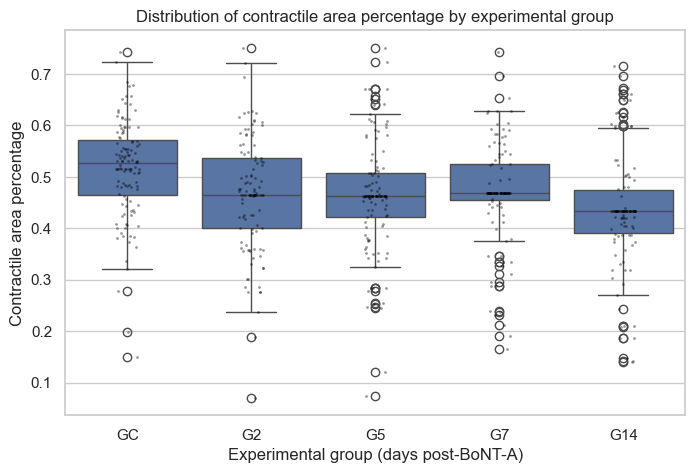

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

order = (
    df_ehat[["group", "days_post_btx"]]
    .drop_duplicates()
    .sort_values("days_post_btx")["group"]
    .tolist()
)

plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_ehat,
    x="group",
    y="pct_contractile_area",
    order=order,
    showfliers=True
)
sns.stripplot(
    data=df_ehat,
    x="group",
    y="pct_contractile_area",
    order=order,
    color="black",
    alpha=0.4,
    size=2,
    jitter=True
)

plt.xlabel("Experimental group (days post-BoNT-A)")
plt.ylabel("Contractile area percentage")
plt.title("Distribution of contractile area percentage by experimental group")

save_figure("pct_contractile_area_by_group")
plt.show()

Kruskal–Wallis

In [24]:
%pip install scipy

from scipy.stats import kruskal

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
groups_data = [
    df_ehat.loc[df_ehat["group"] == g, "pct_contractile_area"].dropna().values
    for g in order
]

kw_stat, kw_p = kruskal(*groups_data)

n_total = len(df_ehat)
k = len(order)
epsilon_sq = (kw_stat - k + 1) / (n_total - k)

kw_text = (
    "Kruskal–Wallis test for contractile area percentage\n"
    f"H statistic = {kw_stat:.3f}\n"
    f"p-value = {kw_p:.6f}\n"
    f"Effect size (epsilon²) ≈ {epsilon_sq:.3f}\n"
)

print(kw_text)
save_text(kw_text, "kruskal_wallis_pct_contractile")

Kruskal–Wallis test for contractile area percentage
H statistic = 50.416
p-value = 0.000000
Effect size (epsilon²) ≈ 0.082

Text saved: results\statistics\text\kruskal_wallis_pct_contractile_20251223_142352.txt


Dunn and Holm

In [26]:
%pip install scikit_posthocs

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
import scikit_posthocs as sp

dunn = sp.posthoc_dunn(
    df_ehat,
    val_col="pct_contractile_area",
    group_col="group",
    p_adjust="holm"
)

dunn = dunn.loc[order, order]

display(dunn.round(4))
save_table(dunn.round(6), "dunn_holm_pct_contractile", index=True)

,GC,G2,G5,G7,G14
GC,1.0000,0.0008,0.0000,0.0153,0.0000
G2,0.0008,1.0000,0.7784,0.7784,0.0164
G5,0.0000,0.7784,1.0000,0.4346,0.0599
G7,0.0153,0.7784,0.4346,1.0000,0.0010
G14,0.0000,0.0164,0.0599,0.0010,1.0000


Table saved: results\statistics\tables\dunn_holm_pct_contractile_20251223_142352.csv


## EHAT prediction

Load EHAT dataset + define targets

In [28]:
df_ehat = read_table("ehat_dataset")

required_cols = {"ehat_norm", "group", "days_post_btx"}
missing = sorted(list(required_cols - set(df_ehat.columns)))
if missing:
    raise ValueError(f"Missing required EHAT columns: {missing}. Found: {list(df_ehat.columns)}")

# Predictor and targets
X = df_ehat[["ehat_norm"]].copy()
y_group = df_ehat["group"].astype(str).str.strip().str.upper()
y_days = pd.to_numeric(df_ehat["days_post_btx"], errors="raise").astype(int)

# Fixed group->days mapping (used to compute MAE_days from predicted groups)
GROUP_TO_DAYS = {"GC": 0, "G2": 2, "G5": 5, "G7": 7, "G14": 14}
valid_groups = set(GROUP_TO_DAYS.keys())

unknown = sorted(set(y_group.unique()) - valid_groups)
if unknown:
    raise ValueError(f"Unknown group labels found: {unknown}. Expected only: {sorted(valid_groups)}")

print(f"EHAT dataset loaded: shape={df_ehat.shape}")
print("Class distribution:")
print(y_group.value_counts())


EHAT dataset loaded: shape=(571, 5)
Class distribution:
group
G5     121
GC     120
G2     110
G7     110
G14    110
Name: count, dtype: int64


EHAT class - Cross-validation evaluation (Logistic Regression, multinomial)

In [29]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, confusion_matrix

# Choose CV strategy
USE_GROUPS = "animal_id" in df_ehat.columns
if USE_GROUPS:
    groups = df_ehat["animal_id"].astype(str).values
    cv = GroupKFold(n_splits=5)
    split_iter = cv.split(X, y_group, groups=groups)
    cv_name = "GroupKFold(5) using animal_id"
else:
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    split_iter = cv.split(X, y_group)
    cv_name = "StratifiedKFold(5) (animal_id not available)"

print(f"CV strategy: {cv_name}")

# Model: multinomial logistic regression
clf = LogisticRegression(
    solver="lbfgs",
    max_iter=5000,
    random_state=42
)

labels_order = ["GC", "G2", "G5", "G7", "G14"]

fold_rows = []
cm_total = np.zeros((len(labels_order), len(labels_order)), dtype=int)

for fold, (train_idx, test_idx) in enumerate(split_iter, start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_group.iloc[train_idx], y_group.iloc[test_idx]

    clf.fit(X_train, y_train)
    y_pred = pd.Series(clf.predict(X_test), index=y_test.index)

    # Metrics
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    kappa_w = cohen_kappa_score(y_test, y_pred, labels=labels_order, weights="quadratic")

    # MAE in days derived from predicted groups
    y_true_days = y_test.map(GROUP_TO_DAYS).astype(int)
    y_pred_days = y_pred.map(GROUP_TO_DAYS).astype(int)
    mae_days = np.mean(np.abs(y_true_days.values - y_pred_days.values))

    fold_rows.append({
        "fold": fold,
        "n_test": len(test_idx),
        "balanced_accuracy": bal_acc,
        "weighted_kappa_quadratic": kappa_w,
        "mae_days": mae_days
    })

    # Confusion matrix (pooled)
    cm = confusion_matrix(y_test, y_pred, labels=labels_order)
    cm_total += cm

df_folds = pd.DataFrame(fold_rows)

summary = pd.DataFrame({
    "metric": ["balanced_accuracy", "weighted_kappa_quadratic", "mae_days"],
    "mean": [
        df_folds["balanced_accuracy"].mean(),
        df_folds["weighted_kappa_quadratic"].mean(),
        df_folds["mae_days"].mean()
    ],
    "sd": [
        df_folds["balanced_accuracy"].std(ddof=1),
        df_folds["weighted_kappa_quadratic"].std(ddof=1),
        df_folds["mae_days"].std(ddof=1)
    ]
})

cm_df = pd.DataFrame(cm_total, index=labels_order, columns=labels_order)

# Display
display(df_folds)
display(summary)
display(cm_df)

# Save outputs
save_table(df_folds.round(6), "ehat_group_classification_folds", index=False)
save_table(summary.round(6), "ehat_group_classification_summary", index=False)
save_table(cm_df, "ehat_group_classification_confusion_matrix", index=True)

text = (
    "EHAT-based group classification (multinomial logistic regression)\n"
    f"CV strategy: {cv_name}\n"
    f"n_samples: {len(df_ehat)}\n"
    "Metrics (mean ± SD across folds):\n"
    f"- Balanced accuracy: {summary.loc[summary.metric=='balanced_accuracy','mean'].values[0]:.4f} "
    f"± {summary.loc[summary.metric=='balanced_accuracy','sd'].values[0]:.4f}\n"
    f"- Weighted kappa (quadratic): {summary.loc[summary.metric=='weighted_kappa_quadratic','mean'].values[0]:.4f} "
    f"± {summary.loc[summary.metric=='weighted_kappa_quadratic','sd'].values[0]:.4f}\n"
    f"- MAE (days): {summary.loc[summary.metric=='mae_days','mean'].values[0]:.4f} "
    f"± {summary.loc[summary.metric=='mae_days','sd'].values[0]:.4f}\n"
)
print(text)
save_text(text, "ehat_group_classification_report")

CV strategy: StratifiedKFold(5) (animal_id not available)


,fold,n_test,balanced_accuracy,weighted_kappa_quadratic,mae_days
0,1,115,0.290697,0.225749,4.408696
1,2,114,0.268939,0.089701,5.043860
2,3,114,0.268939,0.333820,4.403509
3,4,114,0.255303,0.183732,4.771930
4,5,114,0.314394,0.260603,4.210526


,metric,mean,sd
0,balanced_accuracy,0.279655,0.023192
1,weighted_kappa_quadratic,0.218721,0.090722
2,mae_days,4.567704,0.334758


,GC,G2,G5,G7,G14
GC,82,0,25,0,13
G2,42,0,41,0,27
G5,37,0,59,0,25
G7,33,0,60,0,17
G14,25,0,60,0,25


Table saved: results\statistics\tables\ehat_group_classification_folds_20251223_142352.csv
Table saved: results\statistics\tables\ehat_group_classification_summary_20251223_142352.csv
Table saved: results\statistics\tables\ehat_group_classification_confusion_matrix_20251223_142352.csv
EHAT-based group classification (multinomial logistic regression)
CV strategy: StratifiedKFold(5) (animal_id not available)
n_samples: 571
Metrics (mean ± SD across folds):
- Balanced accuracy: 0.2797 ± 0.0232
- Weighted kappa (quadratic): 0.2187 ± 0.0907
- MAE (days): 4.5677 ± 0.3348

Text saved: results\statistics\text\ehat_group_classification_report_20251223_142352.txt


EHAT regression

In [31]:
try:
    from sklearn.model_selection import GroupKFold, KFold
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
except ModuleNotFoundError as e:
    raise ModuleNotFoundError(
        "scikit-learn is required for EHAT regression evaluation. "
        "Install it with: pip install scikit-learn"
    ) from e

Load EHAT dataset (robust) and define variables

In [32]:
# Reuse your robust loader + save helpers already defined:
# - read_table(...)
# - save_table(...)
# - save_text(...)

df_ehat = read_table("ehat_dataset")

required_cols = {"ehat_norm", "days_post_btx"}
missing = sorted(list(required_cols - set(df_ehat.columns)))
if missing:
    raise ValueError(f"Missing required columns in EHAT dataset: {missing}")

X = df_ehat[["ehat_norm"]].astype(float).values
y = df_ehat["days_post_btx"].astype(int).values

USE_GROUPS = "animal_id" in df_ehat.columns
if USE_GROUPS:
    groups = df_ehat["animal_id"].astype(str).values
    cv = GroupKFold(n_splits=5)
    split_iter = cv.split(X, y, groups=groups)
    cv_name = "GroupKFold(5) using animal_id"
else:
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    split_iter = cv.split(X, y)
    cv_name = "KFold(5) with shuffle (animal_id not available)"

print(f"EHAT regression dataset: n={len(df_ehat)}")
print(f"CV strategy: {cv_name}")

EHAT regression dataset: n=571
CV strategy: KFold(5) with shuffle (animal_id not available)


Cross-validated regression (Linear Regression baseline)

In [33]:
model = LinearRegression()

rows = []
y_true_all = []
y_pred_all = []

for fold, (train_idx, test_idx) in enumerate(split_iter, start=1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    r2 = r2_score(y_test, y_pred)

    rows.append({
        "fold": fold,
        "n_test": len(test_idx),
        "mae_days": mae,
        "rmse_days": rmse,
        "r2": r2
    })

    y_true_all.extend(y_test.tolist())
    y_pred_all.extend(y_pred.tolist())

df_folds = pd.DataFrame(rows)

summary = pd.DataFrame({
    "metric": ["mae_days", "rmse_days", "r2"],
    "mean": [
        df_folds["mae_days"].mean(),
        df_folds["rmse_days"].mean(),
        df_folds["r2"].mean(),
    ],
    "sd": [
        df_folds["mae_days"].std(ddof=1),
        df_folds["rmse_days"].std(ddof=1),
        df_folds["r2"].std(ddof=1),
    ]
})

display(df_folds)
display(summary)

# Save outputs
save_table(df_folds.round(6), "ehat_days_regression_linear_folds", index=False)
save_table(summary.round(6), "ehat_days_regression_linear_summary", index=False)

report = (
    "EHAT-based days regression (Linear Regression)\n"
    f"CV strategy: {cv_name}\n"
    f"n_samples: {len(df_ehat)}\n"
    "Metrics (mean ± SD across folds):\n"
    f"- MAE (days): {summary.loc[summary.metric=='mae_days','mean'].values[0]:.4f} "
    f"± {summary.loc[summary.metric=='mae_days','sd'].values[0]:.4f}\n"
    f"- RMSE (days): {summary.loc[summary.metric=='rmse_days','mean'].values[0]:.4f} "
    f"± {summary.loc[summary.metric=='rmse_days','sd'].values[0]:.4f}\n"
    f"- R²: {summary.loc[summary.metric=='r2','mean'].values[0]:.4f} "
    f"± {summary.loc[summary.metric=='r2','sd'].values[0]:.4f}\n"
)

print(report)
save_text(report, "ehat_days_regression_linear_report")

,fold,n_test,mae_days,rmse_days,r2
0,1,115,4.094350,4.951076,0.053194
1,2,114,3.984397,4.818980,-0.082199
2,3,114,3.770058,4.732546,0.055249
3,4,114,3.503427,4.365470,0.094764
4,5,114,3.851914,4.753080,0.026378


,metric,mean,sd
0,mae_days,3.840829,0.225752
1,rmse_days,4.724230,0.217972
2,r2,0.029477,0.067026


Table saved: results\statistics\tables\ehat_days_regression_linear_folds_20251223_142352.csv
Table saved: results\statistics\tables\ehat_days_regression_linear_summary_20251223_142352.csv
EHAT-based days regression (Linear Regression)
CV strategy: KFold(5) with shuffle (animal_id not available)
n_samples: 571
Metrics (mean ± SD across folds):
- MAE (days): 3.8408 ± 0.2258
- RMSE (days): 4.7242 ± 0.2180
- R²: 0.0295 ± 0.0670

Text saved: results\statistics\text\ehat_days_regression_linear_report_20251223_142352.txt


## ERAT prediction

Load ERAT dataset and define variables

In [34]:
# Assumes you already defined:
# - read_table(...)
# - save_table(...)
# - save_text(...)
# - RESULTS_DIR/TABLES_DIR/TEXT_DIR + RUN_ID

X_radiomics = read_table("X_radiomics")
y_group_df = read_table("y_group")
y_days_df = read_table("y_days")

# Standardize target column names
if "group" in y_group_df.columns:
    y_group = y_group_df["group"]
else:
    y_group = y_group_df.iloc[:, 0]
    y_group.name = "group"

if "days_post_btx" in y_days_df.columns:
    y_days = y_days_df["days_post_btx"]
else:
    y_days = y_days_df.iloc[:, 0]
    y_days.name = "days_post_btx"

# Basic integrity checks
nX, ng, nd = len(X_radiomics), len(y_group), len(y_days)
if not (nX == ng == nd):
    raise ValueError(f"Row mismatch: X={nX}, y_group={ng}, y_days={nd}")

# Clean targets
y_group = y_group.astype(str).str.strip().str.upper()
y_days = pd.to_numeric(y_days, errors="raise").astype(int)

print(f"Loaded X_radiomics: {X_radiomics.shape}")
print(f"Loaded y_group: {y_group.shape} | classes={sorted(y_group.unique())}")
print(f"Loaded y_days: {y_days.shape} | unique={sorted(y_days.unique())}")

Loaded X_radiomics: (571, 105)
Loaded y_group: (571,) | classes=['G14', 'G2', 'G5', 'G7', 'GC']
Loaded y_days: (571,) | unique=[np.int64(0), np.int64(2), np.int64(5), np.int64(7), np.int64(14)]


Define metrics and CV strategy

In [35]:
try:
    from sklearn.model_selection import GroupKFold, StratifiedKFold
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, confusion_matrix
except ModuleNotFoundError as e:
    raise ModuleNotFoundError(
        "scikit-learn is required. Install with: pip install scikit-learn"
    ) from e

GROUP_TO_DAYS = {"GC": 0, "G2": 2, "G5": 5, "G7": 7, "G14": 14}
labels_order = ["GC", "G2", "G5", "G7", "G14"]

unknown = sorted(set(y_group.unique()) - set(GROUP_TO_DAYS.keys()))
if unknown:
    raise ValueError(f"Unknown group labels found: {unknown}")

# Group-aware CV if animal_id exists in X_radiomics (or y files)
USE_GROUPS = "animal_id" in X_radiomics.columns
if USE_GROUPS:
    groups = X_radiomics["animal_id"].astype(str).values
    X = X_radiomics.drop(columns=["animal_id"])
    cv = GroupKFold(n_splits=5)
    split_iter = cv.split(X, y_group, groups=groups)
    cv_name = "GroupKFold(5) using animal_id"
else:
    X = X_radiomics.copy()
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    split_iter = cv.split(X, y_group)
    cv_name = "StratifiedKFold(5) (animal_id not available)"

print(f"Predictor matrix X: {X.shape}")
print(f"CV strategy: {cv_name}")

Predictor matrix X: (571, 105)
CV strategy: StratifiedKFold(5) (animal_id not available)


ERAT group classification (multinomial Logistic Regression)

In [36]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, confusion_matrix
from sklearn.model_selection import GroupKFold, StratifiedKFold

# ---- 1) Rebuild CV object safely (do not reuse split_iter) ----
labels_order = ["GC", "G2", "G5", "G7", "G14"]
GROUP_TO_DAYS = {"GC": 0, "G2": 2, "G5": 5, "G7": 7, "G14": 14}

# Ensure inputs exist (X, y_group already created previously)
unknown = sorted(set(y_group.unique()) - set(GROUP_TO_DAYS.keys()))
if unknown:
    raise ValueError(f"Unknown group labels found: {unknown}")

USE_GROUPS = "animal_id" in X_radiomics.columns

if USE_GROUPS:
    groups = X_radiomics["animal_id"].astype(str).values
    X_use = X_radiomics.drop(columns=["animal_id"]).copy()

    n_groups = len(pd.unique(groups))
    if n_groups < 5:
        print(f"Warning: only {n_groups} unique groups found. Falling back to StratifiedKFold.")
        USE_GROUPS = False

if not USE_GROUPS:
    X_use = X.copy() if "X" in globals() else X_radiomics.copy()
    groups = None

# Define CV
if USE_GROUPS:
    cv = GroupKFold(n_splits=5)
    cv_name = f"GroupKFold(5) using animal_id (n_groups={n_groups})"
    splits = list(cv.split(X_use, y_group, groups=groups))
else:
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_name = "StratifiedKFold(5)"
    splits = list(cv.split(X_use, y_group))

print(f"CV strategy: {cv_name}")
print(f"Number of splits: {len(splits)}")
if len(splits) == 0:
    raise RuntimeError("CV produced zero splits. Check group labels, sample size, and CV settings.")

# ---- 2) Define model (MinMaxScaler as pre-defined) ----
clf = Pipeline(steps=[
    ("scaler", MinMaxScaler()),
    ("logreg", LogisticRegression(
        solver="lbfgs",
        max_iter=10000,
        random_state=42
    ))
])

# ---- 3) Run CV ----
rows = []
cm_total = np.zeros((len(labels_order), len(labels_order)), dtype=int)

for fold, (train_idx, test_idx) in enumerate(splits, start=1):
    X_train, X_test = X_use.iloc[train_idx], X_use.iloc[test_idx]
    y_train, y_test = y_group.iloc[train_idx], y_group.iloc[test_idx]

    clf.fit(X_train, y_train)
    y_pred = pd.Series(clf.predict(X_test), index=y_test.index)

    bal_acc = balanced_accuracy_score(y_test, y_pred)
    kappa_w = cohen_kappa_score(y_test, y_pred, labels=labels_order, weights="quadratic")

    y_true_days = y_test.map(GROUP_TO_DAYS).astype(int)
    y_pred_days = y_pred.map(GROUP_TO_DAYS).astype(int)
    mae_days = float(np.mean(np.abs(y_true_days.values - y_pred_days.values)))

    rows.append({
        "fold": fold,
        "n_test": int(len(test_idx)),
        "balanced_accuracy": float(bal_acc),
        "weighted_kappa_quadratic": float(kappa_w),
        "mae_days": float(mae_days)
    })

    cm_total += confusion_matrix(y_test, y_pred, labels=labels_order)

df_folds = pd.DataFrame(rows)

summary = pd.DataFrame({
    "metric": ["balanced_accuracy", "weighted_kappa_quadratic", "mae_days"],
    "mean": [
        df_folds["balanced_accuracy"].mean(),
        df_folds["weighted_kappa_quadratic"].mean(),
        df_folds["mae_days"].mean()
    ],
    "sd": [
        df_folds["balanced_accuracy"].std(ddof=1),
        df_folds["weighted_kappa_quadratic"].std(ddof=1),
        df_folds["mae_days"].std(ddof=1)
    ]
})

cm_df = pd.DataFrame(cm_total, index=labels_order, columns=labels_order)

display(df_folds)
display(summary)
display(cm_df)

# ---- 4) Save outputs ----
save_table(df_folds.round(6), "erat_radiomics_group_logreg_minmax_folds", index=False)
save_table(summary.round(6), "erat_radiomics_group_logreg_minmax_summary", index=False)
save_table(cm_df, "erat_radiomics_group_logreg_minmax_confusion_matrix", index=True)

report = (
    "ERAT (radiomics) group classification — Logistic Regression (MinMax-scaled)\n"
    f"CV strategy: {cv_name}\n"
    f"n_samples: {len(X_use)}\n"
    f"n_features: {X_use.shape[1]}\n"
    "Metrics (mean ± SD across folds):\n"
    f"- Balanced accuracy: {summary.loc[summary.metric=='balanced_accuracy','mean'].values[0]:.4f} "
    f"± {summary.loc[summary.metric=='balanced_accuracy','sd'].values[0]:.4f}\n"
    f"- Weighted kappa (quadratic): {summary.loc[summary.metric=='weighted_kappa_quadratic','mean'].values[0]:.4f} "
    f"± {summary.loc[summary.metric=='weighted_kappa_quadratic','sd'].values[0]:.4f}\n"
    f"- MAE (days): {summary.loc[summary.metric=='mae_days','mean'].values[0]:.4f} "
    f"± {summary.loc[summary.metric=='mae_days','sd'].values[0]:.4f}\n"
)

print(report)
save_text(report, "erat_radiomics_group_logreg_minmax_report")

CV strategy: StratifiedKFold(5)
Number of splits: 5


,fold,n_test,balanced_accuracy,weighted_kappa_quadratic,mae_days
0,1,115,0.745606,0.739121,1.173913
1,2,114,0.803030,0.875696,0.684211
2,3,114,0.833333,0.906191,0.526316
3,4,114,0.831818,0.878878,0.596491
4,5,114,0.823485,0.883298,0.631579


,metric,mean,sd
0,balanced_accuracy,0.807455,0.036623
1,weighted_kappa_quadratic,0.856637,0.066772
2,mae_days,0.722502,0.258782


,GC,G2,G5,G7,G14
GC,103,8,3,6,0
G2,7,80,17,6,0
G5,9,4,103,5,0
G7,9,15,20,66,0
G14,0,0,0,0,110


Table saved: results\statistics\tables\erat_radiomics_group_logreg_minmax_folds_20251223_142352.csv
Table saved: results\statistics\tables\erat_radiomics_group_logreg_minmax_summary_20251223_142352.csv
Table saved: results\statistics\tables\erat_radiomics_group_logreg_minmax_confusion_matrix_20251223_142352.csv
ERAT (radiomics) group classification — Logistic Regression (MinMax-scaled)
CV strategy: StratifiedKFold(5)
n_samples: 571
n_features: 105
Metrics (mean ± SD across folds):
- Balanced accuracy: 0.8075 ± 0.0366
- Weighted kappa (quadratic): 0.8566 ± 0.0668
- MAE (days): 0.7225 ± 0.2588

Text saved: results\statistics\text\erat_radiomics_group_logreg_minmax_report_20251223_142352.txt


ERAT group classification (LightGBM)

In [37]:
%pip install lightgbm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [38]:
import importlib.util

def _has_module(name: str) -> bool:
    return importlib.util.find_spec(name) is not None

if not _has_module("lightgbm"):
    raise ModuleNotFoundError(
        "lightgbm is required for this step. Install it with:\n"
        "  %pip install lightgbm\n"
        "Then restart the kernel and re-run this cell."
    )

import lightgbm as lgb

In [39]:
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

# ---- Rebuild X / y safely from processed artifacts (recommended) ----
X_radiomics = read_table("X_radiomics")
y_group_df = read_table("y_group")

y_group = (y_group_df["group"] if "group" in y_group_df.columns else y_group_df.iloc[:, 0])
y_group = y_group.astype(str).str.strip().str.upper()

GROUP_TO_DAYS = {"GC": 0, "G2": 2, "G5": 5, "G7": 7, "G14": 14}
labels_order = ["GC", "G2", "G5", "G7", "G14"]

unknown = sorted(set(y_group.unique()) - set(GROUP_TO_DAYS.keys()))
if unknown:
    raise ValueError(f"Unknown group labels found: {unknown}")

# CV strategy (same logic as before)
USE_GROUPS = "animal_id" in X_radiomics.columns
if USE_GROUPS:
    groups = X_radiomics["animal_id"].astype(str).values
    X_use = X_radiomics.drop(columns=["animal_id"]).copy()
    n_groups = len(pd.unique(groups))
    if n_groups < 5:
        print(f"Warning: only {n_groups} unique groups found. Falling back to StratifiedKFold.")
        USE_GROUPS = False
else:
    groups = None

if USE_GROUPS:
    cv = GroupKFold(n_splits=5)
    cv_name = f"GroupKFold(5) using animal_id (n_groups={n_groups})"
    splits = list(cv.split(X_use, y_group, groups=groups))
else:
    X_use = X_radiomics.copy()
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_name = "StratifiedKFold(5)"
    splits = list(cv.split(X_use, y_group))

print(f"CV strategy: {cv_name}")
print(f"n_samples: {len(X_use)} | n_features: {X_use.shape[1]} | splits: {len(splits)}")

# ---- Label encoding for LightGBM multiclass ----
le = LabelEncoder()
y_enc = le.fit_transform(y_group)  # 0..(n_classes-1)
class_names = list(le.classes_)
print("Class order used by LightGBM:", class_names)

# ---- Model hyperparameters (reasonable baseline) ----
# Note: Keep it simple and stable; you can tune later if desired.
params = dict(
    objective="multiclass",
    num_class=len(class_names),
    n_estimators=600,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=42,
    n_jobs=-1
)

model = lgb.LGBMClassifier(**params)

# ---- Optional MinMax scaling (consistent with your pipeline) ----
# Tree models do not require scaling, but we keep it for methodological consistency.
clf = Pipeline(steps=[
    ("scaler", MinMaxScaler()),
    ("lgbm", model)
])

# ---- Evaluate ----
rows = []
cm_total = np.zeros((len(labels_order), len(labels_order)), dtype=int)

for fold, (train_idx, test_idx) in enumerate(splits, start=1):
    X_train, X_test = X_use.iloc[train_idx], X_use.iloc[test_idx]
    y_train, y_test = y_group.iloc[train_idx], y_group.iloc[test_idx]

    clf.fit(X_train, y_train)
    y_pred = pd.Series(clf.predict(X_test), index=y_test.index).astype(str).str.upper()

    bal_acc = balanced_accuracy_score(y_test, y_pred)
    kappa_w = cohen_kappa_score(y_test, y_pred, labels=labels_order, weights="quadratic")

    y_true_days = y_test.map(GROUP_TO_DAYS).astype(int)
    y_pred_days = y_pred.map(GROUP_TO_DAYS).astype(int)
    mae_days = float(np.mean(np.abs(y_true_days.values - y_pred_days.values)))

    rows.append({
        "fold": fold,
        "n_test": int(len(test_idx)),
        "balanced_accuracy": float(bal_acc),
        "weighted_kappa_quadratic": float(kappa_w),
        "mae_days": float(mae_days)
    })

    cm_total += confusion_matrix(y_test, y_pred, labels=labels_order)

df_folds = pd.DataFrame(rows)

summary = pd.DataFrame({
    "metric": ["balanced_accuracy", "weighted_kappa_quadratic", "mae_days"],
    "mean": [
        df_folds["balanced_accuracy"].mean(),
        df_folds["weighted_kappa_quadratic"].mean(),
        df_folds["mae_days"].mean()
    ],
    "sd": [
        df_folds["balanced_accuracy"].std(ddof=1),
        df_folds["weighted_kappa_quadratic"].std(ddof=1),
        df_folds["mae_days"].std(ddof=1)
    ]
})

cm_df = pd.DataFrame(cm_total, index=labels_order, columns=labels_order)

display(df_folds)
display(summary)
display(cm_df)

# ---- Save outputs ----
save_table(df_folds.round(6), "erat_radiomics_group_lgbm_minmax_folds", index=False)
save_table(summary.round(6), "erat_radiomics_group_lgbm_minmax_summary", index=False)
save_table(cm_df, "erat_radiomics_group_lgbm_minmax_confusion_matrix", index=True)

report = (
    "ERAT (radiomics) group classification — LightGBM (MinMax-scaled)\n"
    f"CV strategy: {cv_name}\n"
    f"n_samples: {len(X_use)}\n"
    f"n_features: {X_use.shape[1]}\n"
    "Metrics (mean ± SD across folds):\n"
    f"- Balanced accuracy: {summary.loc[summary.metric=='balanced_accuracy','mean'].values[0]:.4f} "
    f"± {summary.loc[summary.metric=='balanced_accuracy','sd'].values[0]:.4f}\n"
    f"- Weighted kappa (quadratic): {summary.loc[summary.metric=='weighted_kappa_quadratic','mean'].values[0]:.4f} "
    f"± {summary.loc[summary.metric=='weighted_kappa_quadratic','sd'].values[0]:.4f}\n"
    f"- MAE (days): {summary.loc[summary.metric=='mae_days','mean'].values[0]:.4f} "
    f"± {summary.loc[summary.metric=='mae_days','sd'].values[0]:.4f}\n"
)

print(report)
save_text(report, "erat_radiomics_group_lgbm_minmax_report")


CV strategy: StratifiedKFold(5)
n_samples: 571 | n_features: 105 | splits: 5
Class order used by LightGBM: ['G14', 'G2', 'G5', 'G7', 'GC']
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15349
[LightGBM] [Info] Number of data points in the train set: 456, number of used features: 104
[LightGBM] [Info] Start training from score -1.645156
[LightGBM] [Info] Start training from score -1.645156
[LightGBM] [Info] Start training from score -1.558145
[LightGBM] [Info] Start training from score -1.645156
[LightGBM] [Info] Start training from score -1.558145
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

C:\Users\modre\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Total Bins 15432
[LightGBM] [Info] Number of data points in the train set: 457, number of used features: 104
[LightGBM] [Info] Start training from score -1.647347
[LightGBM] [Info] Start training from score -1.647347
[LightGBM] [Info] Start training from score -1.549972
[LightGBM] [Info] Start training from score -1.647347
[LightGBM] [Info] Start training from score -1.560335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

C:\Users\modre\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15441
[LightGBM] [Info] Number of data points in the train set: 457, number of used features: 104
[LightGBM] [Info] Start training from score -1.647347
[LightGBM] [Info] Start training from score -1.647347
[LightGBM] [Info] Start training from score -1.549972
[LightGBM] [Info] Start training from score -1.647347
[LightGBM] [Info] Start training from score -1.560335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

C:\Users\modre\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15439
[LightGBM] [Info] Number of data points in the train set: 457, number of used features: 104
[LightGBM] [Info] Start training from score -1.647347
[LightGBM] [Info] Start training from score -1.647347
[LightGBM] [Info] Start training from score -1.549972
[LightGBM] [Info] Start training from score -1.647347
[LightGBM] [Info] Start training from score -1.560335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

C:\Users\modre\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15440
[LightGBM] [Info] Number of data points in the train set: 457, number of used features: 104
[LightGBM] [Info] Start training from score -1.647347
[LightGBM] [Info] Start training from score -1.647347
[LightGBM] [Info] Start training from score -1.549972
[LightGBM] [Info] Start training from score -1.647347
[LightGBM] [Info] Start training from score -1.560335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

C:\Users\modre\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,fold,n_test,balanced_accuracy,weighted_kappa_quadratic,mae_days
0,1,115,0.923061,0.881413,0.434783
1,2,114,0.921212,0.955906,0.263158
2,3,114,0.939394,0.936234,0.271930
3,4,114,0.973485,0.986838,0.078947
4,5,114,0.957576,0.965055,0.157895


,metric,mean,sd
0,balanced_accuracy,0.942945,0.022511
1,weighted_kappa_quadratic,0.945089,0.039974
2,mae_days,0.241342,0.134319


,GC,G2,G5,G7,G14
GC,111,1,2,6,0
G2,1,106,2,1,0
G5,2,3,111,5,0
G7,2,4,4,100,0
G14,0,0,0,0,110


Table saved: results\statistics\tables\erat_radiomics_group_lgbm_minmax_folds_20251223_142352.csv
Table saved: results\statistics\tables\erat_radiomics_group_lgbm_minmax_summary_20251223_142352.csv
Table saved: results\statistics\tables\erat_radiomics_group_lgbm_minmax_confusion_matrix_20251223_142352.csv
ERAT (radiomics) group classification — LightGBM (MinMax-scaled)
CV strategy: StratifiedKFold(5)
n_samples: 571
n_features: 105
Metrics (mean ± SD across folds):
- Balanced accuracy: 0.9429 ± 0.0225
- Weighted kappa (quadratic): 0.9451 ± 0.0400
- MAE (days): 0.2413 ± 0.1343

Text saved: results\statistics\text\erat_radiomics_group_lgbm_minmax_report_20251223_142352.txt


## Erat regression

ElasticNet

In [40]:
from sklearn.model_selection import GroupKFold, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [41]:
# Load processed artifacts
X_radiomics = read_table("X_radiomics")
y_days_df = read_table("y_days")

y_days = (y_days_df["days_post_btx"] if "days_post_btx" in y_days_df.columns else y_days_df.iloc[:, 0])
y_days = pd.to_numeric(y_days, errors="raise").astype(float)

# CV strategy: GroupKFold if animal_id exists, else KFold (transparent fallback)
USE_GROUPS = "animal_id" in X_radiomics.columns
if USE_GROUPS:
    groups = X_radiomics["animal_id"].astype(str).values
    X = X_radiomics.drop(columns=["animal_id"]).copy()
    cv = GroupKFold(n_splits=5)
    splits = list(cv.split(X, y_days, groups=groups))
    cv_name = f"GroupKFold(5) using animal_id (n_groups={len(pd.unique(groups))})"
else:
    X = X_radiomics.copy()
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    splits = list(cv.split(X, y_days))
    cv_name = "KFold(5) (animal_id not available)"

print(f"ERAT regression (ElasticNet) | CV: {cv_name}")
print(f"n_samples: {len(X)} | n_features: {X.shape[1]} | splits: {len(splits)}")

if len(splits) == 0:
    raise RuntimeError("CV produced zero splits. Check sample size and CV settings.")

# ElasticNet pipeline (MinMax scaling per protocol)
# NOTE: alpha/l1_ratio could be tuned, but we start with stable defaults.
model = Pipeline(steps=[
    ("scaler", MinMaxScaler()),
    ("enet", ElasticNet(
        alpha=0.01,      # baseline; adjust/tune later if needed
        l1_ratio=0.5,    # balanced L1/L2
        max_iter=20000,
        random_state=42
    ))
])

rows = []
for fold, (train_idx, test_idx) in enumerate(splits, start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_days.iloc[train_idx], y_days.iloc[test_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
    r2 = r2_score(y_test, y_pred)

    rows.append({
        "fold": fold,
        "n_test": int(len(test_idx)),
        "mae_days": float(mae),
        "rmse_days": rmse,
        "r2": float(r2)
    })

df_folds = pd.DataFrame(rows)

summary = pd.DataFrame({
    "metric": ["mae_days", "rmse_days", "r2"],
    "mean": [
        df_folds["mae_days"].mean(),
        df_folds["rmse_days"].mean(),
        df_folds["r2"].mean()
    ],
    "sd": [
        df_folds["mae_days"].std(ddof=1),
        df_folds["rmse_days"].std(ddof=1),
        df_folds["r2"].std(ddof=1)
    ]
})

display(df_folds)
display(summary)

# Save outputs
save_table(df_folds.round(6), "erat_radiomics_days_elasticnet_minmax_folds", index=False)
save_table(summary.round(6), "erat_radiomics_days_elasticnet_minmax_summary", index=False)

report = (
    "ERAT (radiomics) regression — ElasticNet (MinMax-scaled)\n"
    f"CV strategy: {cv_name}\n"
    f"n_samples: {len(X)}\n"
    f"n_features: {X.shape[1]}\n"
    "Metrics (mean ± SD across folds):\n"
    f"- MAE (days): {summary.loc[summary.metric=='mae_days','mean'].values[0]:.4f} "
    f"± {summary.loc[summary.metric=='mae_days','sd'].values[0]:.4f}\n"
    f"- RMSE (days): {summary.loc[summary.metric=='rmse_days','mean'].values[0]:.4f} "
    f"± {summary.loc[summary.metric=='rmse_days','sd'].values[0]:.4f}\n"
    f"- R²: {summary.loc[summary.metric=='r2','mean'].values[0]:.4f} "
    f"± {summary.loc[summary.metric=='r2','sd'].values[0]:.4f}\n"
)

print(report)
save_text(report, "erat_radiomics_days_elasticnet_minmax_report")


ERAT regression (ElasticNet) | CV: KFold(5) (animal_id not available)
n_samples: 571 | n_features: 105 | splits: 5


,fold,n_test,mae_days,rmse_days,r2
0,1,115,1.715882,2.042949,0.838796
1,2,114,1.592796,1.891945,0.833193
2,3,114,1.523748,1.831845,0.858451
3,4,114,1.714399,2.079468,0.794598
4,5,114,1.382548,1.704267,0.874826


,metric,mean,sd
0,mae_days,1.585875,0.140241
1,rmse_days,1.910095,0.154236
2,r2,0.839973,0.030259


Table saved: results\statistics\tables\erat_radiomics_days_elasticnet_minmax_folds_20251223_142352.csv
Table saved: results\statistics\tables\erat_radiomics_days_elasticnet_minmax_summary_20251223_142352.csv
ERAT (radiomics) regression — ElasticNet (MinMax-scaled)
CV strategy: KFold(5) (animal_id not available)
n_samples: 571
n_features: 105
Metrics (mean ± SD across folds):
- MAE (days): 1.5859 ± 0.1402
- RMSE (days): 1.9101 ± 0.1542
- R²: 0.8400 ± 0.0303

Text saved: results\statistics\text\erat_radiomics_days_elasticnet_minmax_report_20251223_142352.txt


LightGBM regressor

In [42]:
from sklearn.model_selection import GroupKFold, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from lightgbm import LGBMRegressor

In [43]:
# Load processed artifacts
X_radiomics = read_table("X_radiomics")
y_days_df = read_table("y_days")

y_days = (y_days_df["days_post_btx"] if "days_post_btx" in y_days_df.columns else y_days_df.iloc[:, 0])
y_days = pd.to_numeric(y_days, errors="raise").astype(float)

# CV strategy: GroupKFold if animal_id exists, else KFold (transparent fallback)
USE_GROUPS = "animal_id" in X_radiomics.columns
if USE_GROUPS:
    groups = X_radiomics["animal_id"].astype(str).values
    X = X_radiomics.drop(columns=["animal_id"]).copy()
    cv = GroupKFold(n_splits=5)
    splits = list(cv.split(X, y_days, groups=groups))
    cv_name = f"GroupKFold(5) using animal_id (n_groups={len(pd.unique(groups))})"
else:
    X = X_radiomics.copy()
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    splits = list(cv.split(X, y_days))
    cv_name = "KFold(5) (animal_id not available)"

print(f"ERAT regression (LightGBM) | CV: {cv_name}")
print(f"n_samples: {len(X)} | n_features: {X.shape[1]} | splits: {len(splits)}")

if len(splits) == 0:
    raise RuntimeError("CV produced zero splits. Check sample size and CV settings.")

# LightGBM regression pipeline (MinMax scaling per protocol)
# NOTE: These are stable baseline hyperparameters; tuning can be added later if needed.
model = Pipeline(steps=[
    ("scaler", MinMaxScaler()),
    ("lgbm", LGBMRegressor(
        n_estimators=1200,
        learning_rate=0.03,
        num_leaves=63,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.0,
        reg_lambda=0.0,
        random_state=42,
        n_jobs=-1
    ))
])

rows = []
for fold, (train_idx, test_idx) in enumerate(splits, start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_days.iloc[train_idx], y_days.iloc[test_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
    r2 = r2_score(y_test, y_pred)

    rows.append({
        "fold": fold,
        "n_test": int(len(test_idx)),
        "mae_days": float(mae),
        "rmse_days": rmse,
        "r2": float(r2)
    })

df_folds = pd.DataFrame(rows)

summary = pd.DataFrame({
    "metric": ["mae_days", "rmse_days", "r2"],
    "mean": [
        df_folds["mae_days"].mean(),
        df_folds["rmse_days"].mean(),
        df_folds["r2"].mean()
    ],
    "sd": [
        df_folds["mae_days"].std(ddof=1),
        df_folds["rmse_days"].std(ddof=1),
        df_folds["r2"].std(ddof=1)
    ]
})

display(df_folds)
display(summary)

# Save outputs
save_table(df_folds.round(6), "erat_radiomics_days_lgbm_minmax_folds", index=False)
save_table(summary.round(6), "erat_radiomics_days_lgbm_minmax_summary", index=False)

report = (
    "ERAT (radiomics) regression — LightGBM (MinMax-scaled)\n"
    f"CV strategy: {cv_name}\n"
    f"n_samples: {len(X)}\n"
    f"n_features: {X.shape[1]}\n"
    "Metrics (mean ± SD across folds):\n"
    f"- MAE (days): {summary.loc[summary.metric=='mae_days','mean'].values[0]:.4f} "
    f"± {summary.loc[summary.metric=='mae_days','sd'].values[0]:.4f}\n"
    f"- RMSE (days): {summary.loc[summary.metric=='rmse_days','mean'].values[0]:.4f} "
    f"± {summary.loc[summary.metric=='rmse_days','sd'].values[0]:.4f}\n"
    f"- R²: {summary.loc[summary.metric=='r2','mean'].values[0]:.4f} "
    f"± {summary.loc[summary.metric=='r2','sd'].values[0]:.4f}\n"
)

print(report)
save_text(report, "erat_radiomics_days_lgbm_minmax_report")


ERAT regression (LightGBM) | CV: KFold(5) (animal_id not available)
n_samples: 571 | n_features: 105 | splits: 5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15336
[LightGBM] [Info] Number of data points in the train set: 456, number of used features: 104
[LightGBM] [Info] Start training from score 5.515351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

C:\Users\modre\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\modre\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15442
[LightGBM] [Info] Number of data points in the train set: 457, number of used features: 104
[LightGBM] [Info] Start training from score 5.431072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

C:\Users\modre\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\modre\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\modre\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


,fold,n_test,mae_days,rmse_days,r2
0,1,115,0.731834,1.215519,0.942933
1,2,114,0.675783,1.097721,0.943846
2,3,114,0.558926,0.966690,0.960581
3,4,114,0.720548,1.174557,0.934469
4,5,114,0.638618,0.974402,0.959082


,metric,mean,sd
0,mae_days,0.665142,0.070029
1,rmse_days,1.085778,0.113406
2,r2,0.948182,0.011258


Table saved: results\statistics\tables\erat_radiomics_days_lgbm_minmax_folds_20251223_142352.csv
Table saved: results\statistics\tables\erat_radiomics_days_lgbm_minmax_summary_20251223_142352.csv
ERAT (radiomics) regression — LightGBM (MinMax-scaled)
CV strategy: KFold(5) (animal_id not available)
n_samples: 571
n_features: 105
Metrics (mean ± SD across folds):
- MAE (days): 0.6651 ± 0.0700
- RMSE (days): 1.0858 ± 0.1134
- R²: 0.9482 ± 0.0113

Text saved: results\statistics\text\erat_radiomics_days_lgbm_minmax_report_20251223_142352.txt


## SHAP

In [44]:
from pathlib import Path

SUPPL_DIR = Path("supplementary")
SHAP_DIR = SUPPL_DIR / "shap"
SHAP_CLS_DIR = SHAP_DIR / "classification"
SHAP_REG_DIR = SHAP_DIR / "regression"

for p in [SHAP_CLS_DIR, SHAP_REG_DIR]:
    p.mkdir(parents=True, exist_ok=True)

print("Supplementary SHAP directories created:")
print("-", SHAP_CLS_DIR.resolve())
print("-", SHAP_REG_DIR.resolve())

Supplementary SHAP directories created:
- C:\Users\modre\messeter\supplementary\shap\classification
- C:\Users\modre\messeter\supplementary\shap\regression


In [45]:
%pip install shap

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [46]:
import importlib.util

def _has_module(name: str) -> bool:
    return importlib.util.find_spec(name) is not None

missing = []
for m in ["matplotlib", "shap"]:
    if not _has_module(m):
        missing.append(m)

if missing:
    raise ModuleNotFoundError(
        f"Missing packages: {missing}\n"
        "Install with:\n"
        "  %pip install " + " ".join(missing) + "\n"
        "Then restart the kernel and re-run this cell."
    )

import matplotlib.pyplot as plt
import shap

Load processed data (radiomics, group, days)

In [47]:
X_radiomics = read_table("X_radiomics")
y_group_df = read_table("y_group")
y_days_df = read_table("y_days")

y_group = (y_group_df["group"] if "group" in y_group_df.columns else y_group_df.iloc[:, 0]).astype(str)
y_days  = (y_days_df["days_post_btx"] if "days_post_btx" in y_days_df.columns else y_days_df.iloc[:, 0])
y_days  = pd.to_numeric(y_days, errors="raise").astype(float)

# Optional: drop animal_id for modeling if present
if "animal_id" in X_radiomics.columns:
    X = X_radiomics.drop(columns=["animal_id"]).copy()
else:
    X = X_radiomics.copy()

print(f"X: {X.shape} | y_group: {y_group.shape} | y_days: {y_days.shape}")
print("Groups:", sorted(y_group.unique()))

X: (571, 105) | y_group: (571,) | y_days: (571,)
Groups: ['G14', 'G2', 'G5', 'G7', 'GC']


### SHAP — ERAT Classification (LightGBM)

Fit final LightGBM classifier (same hyperparams as performance)

In [48]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier

# Use same params you used for the classification performance
lgbm_cls = LGBMClassifier(
    objective="multiclass",
    num_class=len(sorted(y_group.unique())),
    n_estimators=600,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=42,
    n_jobs=-1
)

cls_pipe = Pipeline(steps=[
    ("scaler", MinMaxScaler()),
    ("lgbm", lgbm_cls)
])

cls_pipe.fit(X, y_group)
print("Final LightGBM classifier fitted on full dataset.")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19285
[LightGBM] [Info] Number of data points in the train set: 571, number of used features: 104
[LightGBM] [Info] Start training from score -1.646909
[LightGBM] [Info] Start training from score -1.646909
[LightGBM] [Info] Start training from score -1.551599
[LightGBM] [Info] Start training from score -1.646909
[LightGBM] [Info] Start training from score -1.559897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

SHAP for classification (summary plots + importance table)

In [49]:
# Transform X exactly as the model sees it
X_scaled = cls_pipe.named_steps["scaler"].transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

explainer = shap.TreeExplainer(cls_pipe.named_steps["lgbm"])
shap_values = explainer.shap_values(X_scaled_df)  # multiclass: list[array] or array depending on SHAP version

# --- Build aggregated importance across classes ---
# shap_values can be:
# - list of arrays [n_classes] each (n_samples, n_features)
# - or a single array (n_samples, n_features, n_classes)
if isinstance(shap_values, list):
    abs_means = np.mean([np.abs(sv).mean(axis=0) for sv in shap_values], axis=0)
else:
    # shape: (n_samples, n_features, n_classes)
    abs_means = np.abs(shap_values).mean(axis=(0, 2))

imp_cls = pd.DataFrame({
    "feature": X.columns,
    "mean_abs_shap": abs_means
}).sort_values("mean_abs_shap", ascending=False)

# Save table
imp_path = SHAP_CLS_DIR / "shap_classification_feature_importance.csv"
imp_cls.to_csv(imp_path, index=False)
print("Saved:", imp_path)

# --- Plots: bar + beeswarm (aggregated view) ---
# For multiclass, shap.summary_plot works with list of arrays; it will aggregate by class in visualization.
plt.figure()
shap.summary_plot(shap_values, X_scaled_df, plot_type="bar", show=False, max_display=30)
plt.tight_layout()
bar_path = SHAP_CLS_DIR / "shap_classification_summary_bar.png"
plt.savefig(bar_path, dpi=300, bbox_inches="tight")
plt.close()
print("Saved:", bar_path)

plt.figure()
shap.summary_plot(shap_values, X_scaled_df, show=False, max_display=30)
plt.tight_layout()
swarm_path = SHAP_CLS_DIR / "shap_classification_summary_beeswarm.png"
plt.savefig(swarm_path, dpi=300, bbox_inches="tight")
plt.close()
print("Saved:", swarm_path)

# Optional: write a short text note for Supplementary
txt = (
    "SHAP — ERAT classification (LightGBM)\n"
    "Model trained on full dataset with MinMax scaling.\n"
    "Outputs:\n"
    "- summary bar plot (top 30 features)\n"
    "- beeswarm plot (top 30 features)\n"
    "- CSV with mean(|SHAP|) aggregated across classes.\n"
)
(SHAP_CLS_DIR / "README.txt").write_text(txt, encoding="utf-8")
print("Saved:", SHAP_CLS_DIR / "README.txt")

display(imp_cls.head(20))

Saved: supplementary\shap\classification\shap_classification_feature_importance.csv
Saved: supplementary\shap\classification\shap_classification_summary_bar.png
Saved: supplementary\shap\classification\shap_classification_summary_beeswarm.png
Saved: supplementary\shap\classification\README.txt


,feature,mean_abs_shap
10,shapesurfacevolumeratio_delta,1.060315
3,shapemaximum2ddiameterrow_delta,0.685314
92,glszmsizezonenonuniformity_delta,0.543287
101,ngtdmcoarseness_delta,0.439667
98,glszmzonepercentage_delta,0.286277
7,shapeminoraxislength_delta,0.258483
91,glszmlowgraylevelzoneemphasis_delta,0.250549
83,glrlmshortrunlowgraylevelemphasis_delta,0.249364
63,gldmlargedependencelowgraylevelemphasis_delta,0.249275
73,glrlmlongrunhighgraylevelemphasis_delta,0.240974


<Figure size 640x480 with 0 Axes>

### SHAP — ERAT Regression (LightGBM)

Fit final LightGBM regressor (same hyperparams as performance)

In [50]:
from lightgbm import LGBMRegressor

# Use same params you used for the regression performance
lgbm_reg = LGBMRegressor(
    n_estimators=1200,
    learning_rate=0.03,
    num_leaves=63,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=42,
    n_jobs=-1
)

reg_pipe = Pipeline(steps=[
    ("scaler", MinMaxScaler()),
    ("lgbm", lgbm_reg)
])

reg_pipe.fit(X, y_days)
print("Final LightGBM regressor fitted on full dataset.")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19285
[LightGBM] [Info] Number of data points in the train set: 571, number of used features: 104
[LightGBM] [Info] Start training from score 5.490368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

SHAP for regression (summary plots + importance table)

In [51]:
X_scaled = reg_pipe.named_steps["scaler"].transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

explainer = shap.TreeExplainer(reg_pipe.named_steps["lgbm"])
shap_values = explainer.shap_values(X_scaled_df)  # regression: (n_samples, n_features)

imp_reg = pd.DataFrame({
    "feature": X.columns,
    "mean_abs_shap": np.abs(shap_values).mean(axis=0)
}).sort_values("mean_abs_shap", ascending=False)

# Save table
imp_path = SHAP_REG_DIR / "shap_regression_feature_importance.csv"
imp_reg.to_csv(imp_path, index=False)
print("Saved:", imp_path)

# Plots
plt.figure()
shap.summary_plot(shap_values, X_scaled_df, plot_type="bar", show=False, max_display=30)
plt.tight_layout()
bar_path = SHAP_REG_DIR / "shap_regression_summary_bar.png"
plt.savefig(bar_path, dpi=300, bbox_inches="tight")
plt.close()
print("Saved:", bar_path)

plt.figure()
shap.summary_plot(shap_values, X_scaled_df, show=False, max_display=30)
plt.tight_layout()
swarm_path = SHAP_REG_DIR / "shap_regression_summary_beeswarm.png"
plt.savefig(swarm_path, dpi=300, bbox_inches="tight")
plt.close()
print("Saved:", swarm_path)

txt = (
    "SHAP — ERAT regression (LightGBM)\n"
    "Model trained on full dataset with MinMax scaling.\n"
    "Outputs:\n"
    "- summary bar plot (top 30 features)\n"
    "- beeswarm plot (top 30 features)\n"
    "- CSV with mean(|SHAP|) across samples.\n"
)
(SHAP_REG_DIR / "README.txt").write_text(txt, encoding="utf-8")
print("Saved:", SHAP_REG_DIR / "README.txt")

display(imp_reg.head(20))


Saved: supplementary\shap\regression\shap_regression_feature_importance.csv
Saved: supplementary\shap\regression\shap_regression_summary_bar.png
Saved: supplementary\shap\regression\shap_regression_summary_beeswarm.png
Saved: supplementary\shap\regression\README.txt


,feature,mean_abs_shap
3,shapemaximum2ddiameterrow_delta,1.631406
8,shapesphericity_delta,0.640002
10,shapesurfacevolumeratio_delta,0.582298
23,firstorderrange_delta,0.291087
101,ngtdmcoarseness_delta,0.264015
92,glszmsizezonenonuniformity_delta,0.227890
67,gldmsmalldependencelowgraylevelemphasis_delta,0.226616
73,glrlmlongrunhighgraylevelemphasis_delta,0.222258
28,firstorderuniformity_delta,0.220564
57,gldmdependencevariance_delta,0.163613


## ERAT x EHAT

Load df_model_with_ehat and validate required columns

In [53]:
PROCESSED_DIR = Path("data/processed")

df_path = PROCESSED_DIR / "df_model_with_ehat.parquet"
assert df_path.exists(), f"Missing: {df_path.resolve()}"

df = pd.read_parquet(df_path)

required = {"ehat_norm", "group", "days_post_btx"}
missing = required - set(df.columns)
assert not missing, f"df_model_with_ehat is missing columns: {missing}"

print("Loaded df_model_with_ehat:", df.shape)
display(df[["group", "days_post_btx", "ehat_norm"]].head())

Loaded df_model_with_ehat: (571, 109)


,group,days_post_btx,ehat_norm
0,GC,0,0.391910
1,GC,0,0.505023
2,GC,0,0.568629
3,GC,0,0.204136
4,GC,0,0.109739


Define feature set (radiomics) and targets

In [55]:
RADIOMICS_COLS = [
    'shapeleastaxislength_delta', 'shapemajoraxislength_delta', 'shapemaximum2ddiametercolumn_delta',
    'shapemaximum2ddiameterrow_delta', 'shapemaximum2ddiameterslice_delta', 'shapemaximum3ddiameter_delta',
    'shapemeshvolume_delta', 'shapeminoraxislength_delta', 'shapesphericity_delta', 'shapesurfacearea_delta',
    'shapesurfacevolumeratio_delta', 'shapevoxelvolume_delta', 'firstorder10percentile_delta',
    'firstorder90percentile_delta', 'firstorderenergy_delta', 'firstorderentropy_delta',
    'firstorderinterquartilerange_delta', 'firstorderkurtosis_delta', 'firstordermaximum_delta',
    'firstordermeanabsolutedeviation_delta', 'firstordermean_delta', 'firstordermedian_delta',
    'firstorderminimum_delta', 'firstorderrange_delta', 'firstorderrobustmeanabsolutedeviation_delta',
    'firstorderrootmeansquared_delta', 'firstorderskewness_delta', 'firstordertotalenergy_delta',
    'firstorderuniformity_delta', 'firstordervariance_delta', 'glcmautocorrelation_delta',
    'glcmclusterprominence_delta', 'glcmclustershade_delta', 'glcmclustertendency_delta',
    'glcmcontrast_delta',  'glcmcorrelation_delta', 'glcmdifferenceaverage_delta',
    'glcmdifferenceentropy_delta', 'glcmdifferencevariance_delta', 'glcmid_delta', 'glcmidm_delta',
    'glcmidmn_delta', 'glcmidn_delta', 'glcmimc1_delta', 'glcmimc2_delta', 'glcminversevariance_delta',
    'glcmjointaverage_delta', 'glcmjointenergy_delta', 'glcmjointentropy_delta', 'glcmmcc_delta',
    'glcmmaximumprobability_delta', 'glcmsumaverage_delta', 'glcmsumentropy_delta', 'glcmsumsquares_delta',
    'gldmdependenceentropy_delta', 'gldmdependencenonuniformity_delta',
    'gldmdependencenonuniformitynormalized_delta', 'gldmdependencevariance_delta',
    'gldmgraylevelnonuniformity_delta', 'gldmgraylevelvariance_delta', 'gldmhighgraylevelemphasis_delta',
    'gldmlargedependenceemphasis_delta', 'gldmlargedependencehighgraylevelemphasis_delta',
    'gldmlargedependencelowgraylevelemphasis_delta', 'gldmlowgraylevelemphasis_delta',
    'gldmsmalldependenceemphasis_delta', 'gldmsmalldependencehighgraylevelemphasis_delta',
    'gldmsmalldependencelowgraylevelemphasis_delta', 'glrlmgraylevelnonuniformity_delta',
    'glrlmgraylevelnonuniformitynormalized_delta', 'glrlmgraylevelvariance_delta',
    'glrlmhighgraylevelrunemphasis_delta', 'glrlmlongrunemphasis_delta', 'glrlmlongrunhighgraylevelemphasis_delta',
    'glrlmlongrunlowgraylevelemphasis_delta', 'glrlmlowgraylevelrunemphasis_delta', 'glrlmrunentropy_delta',
    'glrlmrunlengthnonuniformity_delta', 'glrlmrunlengthnonuniformitynormalized_delta',
    'glrlmrunpercentage_delta', 'glrlmrunvariance_delta', 'glrlmshortrunemphasis_delta',
    'glrlmshortrunhighgraylevelemphasis_delta', 'glrlmshortrunlowgraylevelemphasis_delta',
    'glszmgraylevelnonuniformity_delta', 'glszmgraylevelnonuniformitynormalized_delta', 'glszmgraylevelvariance_delta',
    'glszmhighgraylevelzoneemphasis_delta', 'glszmlargeareaemphasis_delta',
    'glszmlargeareahighgraylevelemphasis_delta', 'glszmlargearealowgraylevelemphasis_delta',
    'glszmlowgraylevelzoneemphasis_delta', 'glszmsizezonenonuniformity_delta',
    'glszmsizezonenonuniformitynormalized_delta', 'glszmsmallareaemphasis_delta',
    'glszmsmallareahighgraylevelemphasis_delta', 'glszmsmallarealowgraylevelemphasis_delta',
    'glszmzoneentropy_delta', 'glszmzonepercentage_delta', 'glszmzonevariance_delta',
    'ngtdmbusyness_delta', 'ngtdmcoarseness_delta', 'ngtdmcomplexity_delta', 'ngtdmcontrast_delta',
    'ngtdmstrength_delta'
]

missing = [c for c in RADIOMICS_COLS if c not in df.columns]
assert not missing, f"Missing radiomics columns in df_model_with_ehat: {missing[:10]} (and {len(missing)-10} more)" if len(missing) > 10 else f"Missing radiomics columns: {missing}"

X = df[RADIOMICS_COLS].copy()
y_days = df["days_post_btx"].astype(float).copy()

print("X:", X.shape, "| y_days:", y_days.shape)

X: (571, 105) | y_days: (571,)


Fit final ERAT regression model and generate ERAT per image

In [56]:
reg_pipe = Pipeline(steps=[
    ("scaler", MinMaxScaler()),
    ("lgbm", LGBMRegressor(
        n_estimators=1200,
        learning_rate=0.03,
        num_leaves=63,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.0,
        reg_lambda=0.0,
        random_state=42,
        n_jobs=-1
    ))
])

reg_pipe.fit(X, y_days)

erat_days_pred = reg_pipe.predict(X).astype(float)

pmin, pmax = float(np.nanmin(erat_days_pred)), float(np.nanmax(erat_days_pred))
erat_norm = (erat_days_pred - pmin) / (pmax - pmin) if pmax > pmin else np.zeros_like(erat_days_pred)

df_with_erat = df.copy()
df_with_erat["erat_days_pred"] = erat_days_pred
df_with_erat["erat_norm"] = erat_norm

print("Added ERAT predictions:")
display(df_with_erat[["group", "days_post_btx", "ehat_norm", "erat_days_pred", "erat_norm"]].head())

# Save updated dataset
out_parquet = PROCESSED_DIR / "df_model_with_ehat_and_erat.parquet"
out_csv = PROCESSED_DIR / "df_model_with_ehat_and_erat.csv"

df_with_erat.to_parquet(out_parquet, index=False)
df_with_erat.to_csv(out_csv, index=False)

print("Saved:")
print("-", out_parquet)
print("-", out_csv)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19285
[LightGBM] [Info] Number of data points in the train set: 571, number of used features: 104
[LightGBM] [Info] Start training from score 5.490368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

C:\Users\modre\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


,group,days_post_btx,ehat_norm,erat_days_pred,erat_norm
0,GC,0,0.391910,0.000715,0.001603
1,GC,0,0.505023,-0.001245,0.001464
2,GC,0,0.568629,0.000526,0.001590
3,GC,0,0.204136,0.003633,0.001811
4,GC,0,0.109739,-0.003372,0.001312


Saved:
- data\processed\df_model_with_ehat_and_erat.parquet
- data\processed\df_model_with_ehat_and_erat.csv


Build df_compare (minimal columns for ERAT × EHAT)

In [57]:
df_compare = df_with_erat[[
    "erat_norm", "ehat_norm", "group", "days_post_btx",
    "erat_days_pred"
]].copy()

# Optional carry-through if you want later plots
if "pct_contractile_area" in df_with_erat.columns:
    df_compare["pct_contractile_area"] = df_with_erat["pct_contractile_area"].astype(float)
if "pct_contractile_area_norm" in df_with_erat.columns:
    df_compare["pct_contractile_area_norm"] = df_with_erat["pct_contractile_area_norm"].astype(float)

df_compare = df_compare.dropna(subset=["erat_norm", "ehat_norm", "group", "days_post_btx"]).reset_index(drop=True)

print("df_compare:", df_compare.shape)
print("Ranges:")
print("- ERAT_norm:", (df_compare["erat_norm"].min(), df_compare["erat_norm"].max()))
print("- EHAT_norm:", (df_compare["ehat_norm"].min(), df_compare["ehat_norm"].max()))
print("Group counts:", df_compare["group"].value_counts().to_dict())

# Save
df_compare.to_parquet(PROCESSED_DIR / "df_compare_erat_ehat.parquet", index=False)
df_compare.to_csv(PROCESSED_DIR / "df_compare_erat_ehat.csv", index=False)

print("Saved df_compare_erat_ehat to data/processed/")

df_compare: (571, 6)
Ranges:
- ERAT_norm: (np.float64(0.0), np.float64(1.0))
- EHAT_norm: (np.float64(0.0), np.float64(1.0))
Group counts: {'G5': 121, 'GC': 120, 'G2': 110, 'G7': 110, 'G14': 110}
Saved df_compare_erat_ehat to data/processed/


Spearman correlation (ERAT_norm × EHAT_norm) with 95% CI (bootstrap)

In [59]:
from scipy.stats import spearmanr

# ------------------------------------------------------------------
# Load comparison dataset
# ------------------------------------------------------------------
PROCESSED_DIR = Path("data/processed")
RESULTS_DIR = Path("results/statistics")
TABLES_DIR = RESULTS_DIR / "tables"
TEXT_DIR = RESULTS_DIR / "text"

TABLES_DIR.mkdir(parents=True, exist_ok=True)
TEXT_DIR.mkdir(parents=True, exist_ok=True)

df = pd.read_parquet(PROCESSED_DIR / "df_compare_erat_ehat.parquet")

x = df["erat_norm"].values
y = df["ehat_norm"].values

assert len(x) == len(y), "Length mismatch between ERAT and EHAT vectors"

n_samples = len(x)

# ------------------------------------------------------------------
# Spearman correlation
# ------------------------------------------------------------------
rho, p_value = spearmanr(x, y)

# ------------------------------------------------------------------
# Bootstrap 95% CI
# ------------------------------------------------------------------
n_bootstrap = 5000
rng = np.random.default_rng(seed=42)

boot_rhos = np.empty(n_bootstrap)

for i in range(n_bootstrap):
    idx = rng.integers(0, n_samples, size=n_samples)
    boot_rhos[i], _ = spearmanr(x[idx], y[idx])

ci_lower = np.percentile(boot_rhos, 2.5)
ci_upper = np.percentile(boot_rhos, 97.5)

# ------------------------------------------------------------------
# Results table
# ------------------------------------------------------------------
df_results = pd.DataFrame({
    "metric": ["Spearman_rho"],
    "value": [rho],
    "p_value": [p_value],
    "ci_2p5": [ci_lower],
    "ci_97p5": [ci_upper],
    "n_samples": [n_samples]
})

# Save table
table_path = TABLES_DIR / "erat_ehat_spearman_results.csv"
df_results.to_csv(table_path, index=False)

# ------------------------------------------------------------------
# Save textual summary (for manuscript drafting)
# ------------------------------------------------------------------
text_summary = (
    f"Spearman correlation between ERAT_norm and EHAT_norm was "
    f"rho = {rho:.3f}, p < 0.001, "
    f"with a 95% bootstrap confidence interval ranging from "
    f"{ci_lower:.3f} to {ci_upper:.3f} "
    f"(n = {n_samples} ultrasound images)."
)

text_path = TEXT_DIR / "erat_ehat_spearman_summary.txt"
with open(text_path, "w", encoding="utf-8") as f:
    f.write(text_summary)

# ------------------------------------------------------------------
# Display
# ------------------------------------------------------------------
display(df_results)
print(text_summary)
print(f"\nSaved:")
print(f"- Table: {table_path}")
print(f"- Text : {text_path}")


,metric,value,p_value,ci_2p5,ci_97p5,n_samples
0,Spearman_rho,0.233558,1.632197e-08,0.150063,0.313536,571


Spearman correlation between ERAT_norm and EHAT_norm was rho = 0.234, p < 0.001, with a 95% bootstrap confidence interval ranging from 0.150 to 0.314 (n = 571 ultrasound images).

Saved:
- Table: results\statistics\tables\erat_ehat_spearman_results.csv
- Text : results\statistics\text\erat_ehat_spearman_summary.txt


ICC(2,1) ERAT_norm × EHAT_norm (com IC95%)

In [60]:
!pip install pingouin

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 1.4/1.4 MB 11.8 MB/s  0:00:00

   ---------- ----------------------------- 1/4 [xarray]
   ---------- ----------------------------- 1/4 [xarray]
   ---------- ----------------------------- 1/4 [xarray]
   ---------- ----------------------------- 1/4 [xarray]
   ---------- ----------------------------- 1/4 [xarray]
   ---------- ----------------------------- 1/4 [xarray]
   ---------- ----------------------------- 1/4 [xarray]
   ---------- ----------------------------- 1/4 [xarray]
   ---------- ----------------------------- 1/4 [xarray]
   ---------- ----------------------------- 1/4 [xarray]
   ---------- ----------------------------- 1/4 [xarray]
   ---------- ----------------------------- 1/4 [xarray]
   ---------- ----------------------------- 1/4 [xarray]
   ---------- ----------------------------- 1/4 [xarray]
   ---------- ----------------------------- 1/4 [xarray]
 


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [61]:
import pingouin as pg

# ------------------------------------------------------------------
# Paths
# ------------------------------------------------------------------
PROCESSED_DIR = Path("data/processed")
RESULTS_DIR = Path("results/statistics")
TABLES_DIR = RESULTS_DIR / "tables"
TEXT_DIR = RESULTS_DIR / "text"

TABLES_DIR.mkdir(parents=True, exist_ok=True)
TEXT_DIR.mkdir(parents=True, exist_ok=True)

# ------------------------------------------------------------------
# Load comparison dataset
# ------------------------------------------------------------------
df = pd.read_parquet(PROCESSED_DIR / "df_compare_erat_ehat.parquet")

# Prepare long-format dataframe for ICC
df_long = pd.DataFrame({
    "target": list(range(len(df))) * 2,
    "rater": ["ERAT"] * len(df) + ["EHAT"] * len(df),
    "score": pd.concat(
        [df["erat_norm"], df["ehat_norm"]],
        ignore_index=True
    )
})

# ------------------------------------------------------------------
# Compute ICC
# ------------------------------------------------------------------
icc = pg.intraclass_corr(
    data=df_long,
    targets="target",
    raters="rater",
    ratings="score"
)

# Select ICC(2,1)
icc_21 = icc.query("Type == 'ICC2'").copy()

# Save full ICC table (supplementary)
icc_full_path = TABLES_DIR / "erat_ehat_icc_full.csv"
icc.to_csv(icc_full_path, index=False)

# Save ICC(2,1) only (primary)
icc_21_path = TABLES_DIR / "erat_ehat_icc2_1.csv"
icc_21.to_csv(icc_21_path, index=False)

# ------------------------------------------------------------------
# Text summary for manuscript
# ------------------------------------------------------------------
row = icc_21.iloc[0]

text_summary = (
    f"Agreement between ERAT_norm and EHAT_norm was low, "
    f"with an ICC(2,1) of {row['ICC']:.3f} "
    f"(95% CI {row['CI95%'][0]:.2f}–{row['CI95%'][1]:.2f}; "
    f"p = {row['pval']:.4f})."
)

text_path = TEXT_DIR / "erat_ehat_icc2_1_summary.txt"
with open(text_path, "w", encoding="utf-8") as f:
    f.write(text_summary)

# ------------------------------------------------------------------
# Display
# ------------------------------------------------------------------
display(icc_21)
print(text_summary)
print("\nSaved:")
print(f"- ICC full table (supplementary): {icc_full_path}")
print(f"- ICC(2,1) table (primary): {icc_21_path}")
print(f"- Text summary: {text_path}")


,Type,Description,ICC,F,df1,df2,pval,CI95%
1,ICC2,Single random raters,0.156349,1.371235,570,570,0.000085,"[0.08, 0.24]"


Agreement between ERAT_norm and EHAT_norm was low, with an ICC(2,1) of 0.156 (95% CI 0.08–0.24; p = 0.0001).

Saved:
- ICC full table (supplementary): results\statistics\tables\erat_ehat_icc_full.csv
- ICC(2,1) table (primary): results\statistics\tables\erat_ehat_icc2_1.csv
- Text summary: results\statistics\text\erat_ehat_icc2_1_summary.txt


Bland–Altman ERAT_norm × EHAT_norm

In [62]:
# --------------------------------------------------
# Paths
# --------------------------------------------------
RESULTS_DIR = Path("results")
FIGURES_DIR = RESULTS_DIR / "figures"
TABLES_DIR = RESULTS_DIR / "tables"
TEXT_DIR = RESULTS_DIR / "text"

for d in [FIGURES_DIR, TABLES_DIR, TEXT_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# --------------------------------------------------
# Load data
# --------------------------------------------------
df = pd.read_parquet("data/processed/df_compare_erat_ehat.parquet")

erat = df["erat_norm"].values
ehat = df["ehat_norm"].values

mean_vals = (erat + ehat) / 2
diff_vals = erat - ehat

bias = np.mean(diff_vals)
sd = np.std(diff_vals, ddof=1)
loa_lower = bias - 1.96 * sd
loa_upper = bias + 1.96 * sd

# --------------------------------------------------
# Save numeric results
# --------------------------------------------------
ba_table = pd.DataFrame({
    "bias": [bias],
    "loa_lower": [loa_lower],
    "loa_upper": [loa_upper],
    "n_samples": [len(diff_vals)]
})

ba_table_path = TABLES_DIR / "erat_ehat_bland_altman_summary.csv"
ba_table.to_csv(ba_table_path, index=False)

# --------------------------------------------------
# Plot
# --------------------------------------------------
plt.figure(figsize=(7, 5))
plt.scatter(mean_vals, diff_vals, alpha=0.5, s=25)
plt.axhline(bias, linestyle="--", linewidth=2, label=f"Bias = {bias:.2f}")
plt.axhline(loa_lower, linestyle="--", color="gray", label=f"LoA = {loa_lower:.2f}")
plt.axhline(loa_upper, linestyle="--", color="gray", label=f"LoA = {loa_upper:.2f}")

plt.xlabel("Mean of ERAT_norm and EHAT_norm")
plt.ylabel("Difference (ERAT_norm − EHAT_norm)")
plt.title("Bland–Altman Plot: ERAT_norm vs EHAT_norm")
plt.legend()
plt.tight_layout()

fig_path = FIGURES_DIR / "figure_7_bland_altman_erat_ehat.png"
plt.savefig(fig_path, dpi=300)
plt.close()

# --------------------------------------------------
# Text for manuscript
# --------------------------------------------------
text = (
    f"Bland–Altman analysis showed a mean bias of {bias:.2f}, "
    f"with 95% limits of concordance ranging from {loa_lower:.2f} "
    f"to {loa_upper:.2f}, indicating wide dispersion of individual "
    f"differences between ERAT_norm and EHAT_norm."
)

text_path = TEXT_DIR / "erat_ehat_bland_altman_summary.txt"
with open(text_path, "w", encoding="utf-8") as f:
    f.write(text)

print(text)
print("\nSaved:")
print(f"- Figure: {fig_path}")
print(f"- Table: {ba_table_path}")
print(f"- Text: {text_path}")


Bland–Altman analysis showed a mean bias of -0.02, with 95% limits of concordance ranging from -0.70 to 0.66, indicating wide dispersion of individual differences between ERAT_norm and EHAT_norm.

Saved:
- Figure: results\figures\figure_7_bland_altman_erat_ehat.png
- Table: results\tables\erat_ehat_bland_altman_summary.csv
- Text: results\text\erat_ehat_bland_altman_summary.txt


Temporal trajectories ERAT_norm x EHAT_norm

In [64]:
# --------------------------------------------------
# Paths
# --------------------------------------------------
RESULTS_DIR = Path("results")
FIGURES_DIR = RESULTS_DIR / "figures"
TABLES_DIR = RESULTS_DIR / "tables"
TEXT_DIR = RESULTS_DIR / "text"

for d in [FIGURES_DIR, TABLES_DIR, TEXT_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# --------------------------------------------------
# Load data
# --------------------------------------------------
df = pd.read_parquet("data/processed/df_compare_erat_ehat.parquet")

group_order = ["GC", "G2", "G5", "G7", "G14"]
df["group"] = pd.Categorical(df["group"], categories=group_order, ordered=True)

# --------------------------------------------------
# Summary statistics
# --------------------------------------------------
summary = (
    df
    .groupby("group")
    .agg(
        erat_mean=("erat_norm", "mean"),
        erat_sd=("erat_norm", "std"),
        ehat_mean=("ehat_norm", "mean"),
        ehat_sd=("ehat_norm", "std"),
        n=("erat_norm", "size")
    )
    .reset_index()
)

summary_path = TABLES_DIR / "erat_ehat_temporal_means_sd.csv"
summary.to_csv(summary_path, index=False)

# --------------------------------------------------
# Plot
# --------------------------------------------------
plt.figure(figsize=(7, 5))

plt.errorbar(
    summary["group"],
    summary["erat_mean"],
    yerr=summary["erat_sd"],
    marker="o",
    capsize=4,
    label="ERAT_norm (LightGBM)"
)

plt.errorbar(
    summary["group"],
    summary["ehat_mean"],
    yerr=summary["ehat_sd"],
    marker="s",
    capsize=4,
    label="EHAT_norm (Histology)"
)

plt.xlabel("Experimental group (days post-BoNT-A)")
plt.ylabel("Normalized atrophy score")
plt.title("Temporal trajectories of ERAT_norm and EHAT_norm")
plt.legend()
plt.tight_layout()

fig_path = FIGURES_DIR / "figure_8_temporal_curves_erat_ehat.png"
plt.savefig(fig_path, dpi=300)
plt.close()

print("\nSaved:")
print(f"- Figure: {fig_path}")
print(f"- Table: {summary_path}")
print(f"- Text: {text_path}")


C:\Users\modre\AppData\Local\Temp\ipykernel_23992\490853803.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("group")



Saved:
- Figure: results\figures\figure_8_temporal_curves_erat_ehat.png
- Table: results\tables\erat_ehat_temporal_means_sd.csv
- Text: results\text\erat_ehat_temporal_curves_summary.txt


Kruskal–Wallis + Dunn–Holm

In [65]:
!pip install scikit-posthocs


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [66]:
from scipy.stats import kruskal
import scikit_posthocs as sp

# --------------------------------------------------
# Paths
# --------------------------------------------------
RESULTS_DIR = Path("results")
TABLES_DIR = RESULTS_DIR / "tables"
TABLES_DIR.mkdir(parents=True, exist_ok=True)

# --------------------------------------------------
# Load data
# --------------------------------------------------
df = pd.read_parquet("data/processed/df_compare_erat_ehat.parquet")

group_order = ["GC", "G2", "G5", "G7", "G14"]
df["group"] = pd.Categorical(df["group"], categories=group_order, ordered=True)

# --------------------------------------------------
# Helper: epsilon squared
# --------------------------------------------------
def epsilon_squared(H, k, n):
    return (H - k + 1) / (n - k)

# --------------------------------------------------
# Function to run KW + Dunn-Holm
# --------------------------------------------------
def kw_dunn(df, value_col, label):
    groups = [
        df.loc[df["group"] == g, value_col].dropna()
        for g in group_order
    ]

    H, p = kruskal(*groups)
    n = sum(len(g) for g in groups)
    k = len(groups)
    eps2 = epsilon_squared(H, k, n)

    dunn = sp.posthoc_dunn(
        df,
        val_col=value_col,
        group_col="group",
        p_adjust="holm"
    ).loc[group_order, group_order]

    # Save
    summary = pd.DataFrame({
        "metric": ["H", "p_value", "epsilon_squared", "n_samples"],
        "value": [H, p, eps2, n]
    })

    summary_path = TABLES_DIR / f"{label}_kruskal_summary.csv"
    dunn_path = TABLES_DIR / f"{label}_dunn_holm.csv"

    summary.to_csv(summary_path, index=False)
    dunn.to_csv(dunn_path)

    return summary, dunn

# --------------------------------------------------
# Run analyses
# --------------------------------------------------
erat_summary, erat_dunn = kw_dunn(df, "erat_norm", "erat_norm")
ehat_summary, ehat_dunn = kw_dunn(df, "ehat_norm", "ehat_norm")

# --------------------------------------------------
# Display
# --------------------------------------------------
print("ERAT_norm — Kruskal–Wallis summary")
display(erat_summary)
display(erat_dunn)

print("\nEHAT_norm — Kruskal–Wallis summary")
display(ehat_summary)
display(ehat_dunn)

print("\nTables saved to results/tables/")


ERAT_norm — Kruskal–Wallis summary


,metric,value
0,H,5.470615e+02
1,p_value,4.422787e-117
2,epsilon_squared,9.594726e-01
3,n_samples,5.710000e+02


,GC,G2,G5,G7,G14
GC,1.000000e+00,4.284592e-07,1.478194e-26,6.888347e-56,2.348169e-96
G2,4.284592e-07,1.000000e+00,4.284592e-07,1.757946e-24,3.923262e-52
G5,1.478194e-26,4.284592e-07,1.000000e+00,4.284592e-07,1.757946e-24
G7,6.888347e-56,1.757946e-24,4.284592e-07,1.000000e+00,7.622273e-07
G14,2.348169e-96,3.923262e-52,1.757946e-24,7.622273e-07,1.000000e+00



EHAT_norm — Kruskal–Wallis summary


,metric,value
0,H,5.041848e+01
1,p_value,2.952715e-10
2,epsilon_squared,8.201144e-02
3,n_samples,5.710000e+02


,GC,G2,G5,G7,G14
GC,1.000000e+00,0.000776,0.000041,0.015250,5.136785e-11
G2,7.760009e-04,1.000000,0.778355,0.778355,1.638287e-02
G5,4.118154e-05,0.778355,1.000000,0.434623,5.986104e-02
G7,1.524954e-02,0.778355,0.434623,1.000000,1.006215e-03
G14,5.136785e-11,0.016383,0.059861,0.001006,1.000000e+00



Tables saved to results/tables/
